In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

from torch.utils.data import Subset

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
# from deepadr.model_gnn import GCN as testGCN
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf
# from deepadr.model_attn_siamese import *
from ogb.graphproppred import Evaluator
os.chdir(cwd)

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
# from tdc.single_pred import Tox
from tdc.multi_pred import DDI

In [8]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [9]:
report_available_cuda_devices()

number of GPUs available: 1
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB



In [10]:
n_gpu = torch.cuda.device_count()
n_gpu

1

In [11]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

In [12]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


### Preparing dataset 

In [13]:
# TDC Tox
DSdataset_name = 'DrugBank' #'TWOSIDES' #'DrugBank'

#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [14]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# # ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))
print(targetdata_dir)

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
/cluster/home/skyriakos/chemprop_run/git/data/processed/DrugBank/data_v1


In [15]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/DrugBank/data_v1'

In [16]:
%%time
dataset = MoleculeDataset(root=targetdata_dir)

CPU times: user 0 ns, sys: 1.18 s, total: 1.18 s
Wall time: 1.18 s


In [17]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: MoleculeDataset(446985):
Number of graphs: 446985
Number of features: 9
Number of classes: 12


In [18]:
data0

PairData(edge_index_a=[2, 38], x_a=[17, 9], edge_attr_a=[38, 3], edge_index_b=[2, 16], x_b=[9, 9], edge_attr_b=[16, 3], id=[1], y=[1])

In [19]:
len(dataset)

446985

In [20]:
torch.manual_seed(42)
dataset = dataset.shuffle()

In [21]:
# used_dataset = dataset

smaller_dataset_len = int(len(dataset)/10)
used_dataset = dataset[:smaller_dataset_len]

In [22]:
smaller_dataset_len

44698

In [23]:
len(used_dataset)

44698

In [24]:
fold_partitions = get_stratified_partitions(used_dataset.data.y[:smaller_dataset_len], num_folds=10, valid_set_portion=0.1, random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.9336555724347466
class: 1 norm count: 0.0013810247203424942
class: 2 norm count: 0.00464024306035078
class: 3 norm count: 0.00936334760392211
class: 4 norm count: 0.005993647286286425
class: 5 norm count: 0.0075956359618837175
class: 6 norm count: 0.0036459052617041844
class: 7 norm count: 0.011241541223587902
class: 8 norm count: 0.004253556138654882
class: 9 norm count: 0.0006076508769506974
class: 10 norm count: 0.017373290981908575
class: 11 norm count: 0.00024858444966164894
validation data
class: 0 norm count: 0.9336316181953765
class: 1 norm count: 0.0012428535918468805
class: 2 norm count: 0.004722843649018146
class: 3 norm count: 0.009445687298036291
class: 4 norm count: 0.005965697240865026
class: 5 norm count: 0.007705692269450659
class: 6 norm count: 0.0037285607755406414
class: 7 norm count: 0.011185682326621925
class: 8 norm count: 0.004225702212279393
class: 9 norm count: 0.0004971414367387521
class: 10 norm count: 0.01739995

fold_num: 6
train data
class: 0 norm count: 0.9336831929291535
class: 1 norm count: 0.0013810247203424942
class: 2 norm count: 0.00461262256594393
class: 3 norm count: 0.00933572710951526
class: 4 norm count: 0.005993647286286425
class: 5 norm count: 0.0075956359618837175
class: 6 norm count: 0.0036735257561110344
class: 7 norm count: 0.011241541223587902
class: 8 norm count: 0.004253556138654882
class: 9 norm count: 0.0005800303825438476
class: 10 norm count: 0.017373290981908575
class: 11 norm count: 0.00027620494406849883
validation data
class: 0 norm count: 0.9336316181953765
class: 1 norm count: 0.0012428535918468805
class: 2 norm count: 0.004722843649018146
class: 3 norm count: 0.009445687298036291
class: 4 norm count: 0.005965697240865026
class: 5 norm count: 0.007705692269450659
class: 6 norm count: 0.0037285607755406414
class: 7 norm count: 0.011185682326621925
class: 8 norm count: 0.004225702212279393
class: 9 norm count: 0.0004971414367387521
class: 10 norm count: 0.01739995

In [25]:
fold_partitions[0]

{'train': array([41053, 27202, 35291, ..., 36574, 30929, 20872]),
 'validation': array([40073, 10928, 37256, ..., 38730, 35492, 25467]),
 'test': array([   19,    22,    25, ..., 44686, 44687, 44696])}

In [26]:
# train_val_test_frac = [0.7, 0.1, 0.2]
# assert sum(train_val_test_frac) == 1

# torch.manual_seed(42)
# used_dataset = used_dataset.shuffle()

# num_train = round(train_val_test_frac[0] * len(used_dataset)) 
# num_trainval = round((train_val_test_frac[0]+train_val_test_frac[1]) * len(used_dataset))

# train_dataset = used_dataset[:num_train]
# val_dataset = used_dataset[num_train:num_trainval]
# test_dataset = used_dataset[num_trainval:]

In [27]:
train_dataset = Subset(used_dataset, fold_partitions[0]['train'])
val_dataset = Subset(used_dataset, fold_partitions[0]['validation'])
test_dataset = Subset(used_dataset, fold_partitions[0]['test'])

In [28]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 36205
Number of val graphs: 4023
Number of test graphs: 4470


In [29]:
# train_dataset[3]

In [30]:
print(dataset.num_classes)

12


In [31]:
# training params
tp = {
    "batch_size" : 128,
    
    "emb_dim" : 300,
    "gnn_type" : "gatv2",
    "num_layer" : 5,
    "graph_pooling" : "mean", #attention
    
    "input_embed_dim" : None,
    "num_attn_heads" : 2,
    "num_transformer_units" : 1,
    "p_dropout" : 0.3,
    "nonlin_func" : nn.ReLU(),
    "mlp_embed_factor" : 2,
    "pooling_mode" : 'attn',
    "dist_opt" : 'cosine',

    "num_epochs" : 100,
    "l2_reg" : 1e-6,
    "loss_w" : 0.05,
    "margin_v" : 1.,

    "expression_dim" : 0,
    "expression_input_size" : 8785,
    "exp_H1" : 500,
    "exp_H2" : 300

}

In [32]:
fdtype = torch.float32

In [33]:
y_weights = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_weights.pkl'))
class_weights = torch.tensor(y_weights).type(fdtype).to(device_gpu)
class_weights

tensor([8.8831e-02, 3.6843e+01, 1.2059e+01, 1.1788e+01, 1.7662e+01, 5.9219e+01,
        3.0938e+01, 6.0666e+00, 5.6098e+01, 3.9796e+01, 4.4360e+00, 1.1497e+02],
       device='cuda:0')

In [34]:
# def make_weights_for_balanced_classes(images, nclasses):                        
#     count = [0] * nclasses                                                      
#     for item in images:                                                         
#         count[item[1]] += 1                                                     
#     weight_per_class = [0.] * nclasses                                      
#     N = float(sum(count))                                                   
#     for i in range(nclasses):                                                   
#         weight_per_class[i] = N/float(count[i])                                 
#     weight = [0] * len(images)                                              
#     for idx, val in enumerate(images):                                          
#         weight[idx] = weight_per_class[val[1]]                                  
#     return weight

In [35]:
# sampler = WeightedRandomSampler(class_weights, tp["batch_size"])                     

In [36]:
# with Sampler

# train_loader = DataLoader(train_dataset, batch_size=tp["batch_size"], shuffle=False, sampler = WeightedRandomSampler(class_weights, len(train_dataset)), follow_batch=['x_a', 'x_b'])
# valid_loader = DataLoader(val_dataset, batch_size=tp["batch_size"], shuffle=False, sampler = sampler, follow_batch=['x_a', 'x_b'])
# test_loader = DataLoader(test_dataset, batch_size=tp["batch_size"], shuffle=False, sampler = sampler, follow_batch=['x_a', 'x_b'])

In [37]:
len(train_dataset)

36205

In [38]:
# without Sampler

train_loader = DataLoader(train_dataset, batch_size=tp["batch_size"], shuffle=True, follow_batch=['x_a', 'x_b'])
valid_loader = DataLoader(val_dataset, batch_size=tp["batch_size"], shuffle=False, follow_batch=['x_a', 'x_b'])
test_loader = DataLoader(test_dataset, batch_size=tp["batch_size"], shuffle=False, follow_batch=['x_a', 'x_b'])

In [39]:
# for batch in train_loader:
#     print(batch.y)

In [40]:
gnn_model = GNN(gnn_type = tp["gnn_type"], 
#                 num_tasks = dataset.num_classes, 
                num_layer = tp["num_layer"], 
                emb_dim = tp["emb_dim"], 
                drop_ratio = 0.5, 
                JK = "last",
                graph_pooling = tp["graph_pooling"],
                virtual_node = False,
                with_edge_attr=False).to(device_gpu)

In [41]:
# transformer_model = DeepAdr_Transformer(input_size=tp["emb_dim"],
#                                         input_embed_dim=tp["input_embed_dim"],
#                                         num_attn_heads=tp["num_attn_heads"],
#                                         mlp_embed_factor=tp["mlp_embed_factor"],
#                                         nonlin_func=tp["nonlin_func"],
#                                         pdropout=tp["p_dropout"],
#                                         num_transformer_units=tp["num_transformer_units"],
#                                         pooling_mode=tp["pooling_mode"]).to(device_gpu)

In [42]:
siamese_model = DeepAdr_SiameseTrf(input_dim=tp["emb_dim"],
                                   dist=tp["dist_opt"],
                                   expression_dim=tp["expression_dim"],
                                   num_classes=dataset.num_classes).to(device_gpu)

updated
num classes: 12


In [43]:
# models_param = list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(siamese_model.parameters()) + list(expression_model.parameters())
models_param = list(gnn_model.parameters()) + list(siamese_model.parameters())


model_name = "ogb"
models = [(gnn_model, f'{model_name}_GNN'),
#           (transformer_model, f'{model_name}_Transformer'),
          (siamese_model, f'{model_name}_Siamese'),
#           (expression_model, f'{model_name}_Expression'),
#           (lassonet_model, f'{model_name}_LassoNet')
         ]
#models

In [44]:
# model_name = "ogb"

# gnn_model = GNN(gnn_type = 'gatv2', 
# #                     num_tasks = dataset.num_classes, 
#                     num_layer = 5, 
#                     emb_dim = emb_dim, 
#                     drop_ratio = 0.5, 
#                     virtual_node = False,
#                     with_edge_attr=False,
#                     JK = "last"
#                    ).to(device_gpu)
# #print(deepadr_model)

In [45]:
# input_embed_dim = None
# num_attn_heads = 2
# num_transformer_units = 1
# p_dropout = 0.3
# nonlin_func = nn.ReLU()
# mlp_embed_factor = 2
# pooling_mode = 'attn'

# dist_opt = 'cosine'
# l2_reg = 1e-6
# batch_size = 1000
# num_epochs = 100
# loss_w = 0.05
# margin_v = 1.

# transformer_model = DeepAdr_Transformer(input_size=emb_dim,
#                                         input_embed_dim=input_embed_dim,
#                                         num_attn_heads=num_attn_heads,
#                                         mlp_embed_factor=mlp_embed_factor,
#                                         nonlin_func=nonlin_func,
#                                         pdropout=p_dropout,
#                                         num_transformer_units=num_transformer_units,
#                                         pooling_mode=pooling_mode).to(device_gpu)

In [46]:
# deepadr_siamese = DeepAdr_SiameseTrf(input_dim=emb_dim,
#                                      expression_dim=0,
#                                    dist=dist_opt,
#                                    num_classes=dataset.num_classes).to(device_gpu)

In [47]:
# models_param = list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(deepadr_siamese.parameters())
# # models_param = list(gnn_model.parameters()) + list(deepadr_siamese.parameters())


# models = [(gnn_model, f'{model_name}_GNN'),
# #           (transformer_model, f'{model_name}_Transformer'),
#           (deepadr_siamese, f'{model_name}_Siamese')]
# #models

In [48]:
# # from IPython.display import Javascript
# # display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# optimizer = torch.optim.Adam(models_param, lr=0.001)
# # criterion = torch.nn.CrossEntropyLoss()

# # loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
# loss_nlll = torch.nn.NLLLoss(reduction='mean')  # negative log likelihood loss
# loss_contrastive = ContrastiveLoss(0.5, reduction='mean')
# fdtype = torch.float32
# loss_w = 0.1

# # evaluator = Evaluator(DSdataset_name)

In [49]:
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

num_iter = len(train_loader)  # num_train_samples/batch_size
c_step_size = int(np.ceil(5*num_iter))  # this should be 2-10 times num_iter

base_lr = 3e-4
max_lr = 5*base_lr  # 3-5 times base_lr
optimizer = torch.optim.Adam(models_param, weight_decay=tp["l2_reg"], lr=base_lr)
cyc_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=c_step_size,
                                                mode='triangular', cycle_momentum=False)
# optimizer = torch.optim.Adam(models_param, lr=0.001)
# criterion = torch.nn.CrossEntropyLoss()

# loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
loss_contrastive = ContrastiveLoss(0.5, reduction='mean')
# loss_mse = torch.nn.MSELoss()  # this is for regression mean squared loss


# evaluator = Evaluator(DSdataset_name)

In [50]:
def train():
    for m, m_name in models:
        m.train()

        #            for i_batch, samples_batch in enumerate(data_loader):

#     for data in train_loader:  # Iterate in batches over the training dataset.
    for i_batch, batch in enumerate(tqdm(train_loader, desc="Iteration")):
#         print("batch len:", len(batch))
        
        batch = batch.to(device_gpu)
#         print("running batch:", i_batch)
        # x, edge_index, edge_attr, batch
        h_a = gnn_model(batch.x_a, batch.edge_index_a, batch.edge_attr_a, batch.x_a_batch)
        h_b = gnn_model(batch.x_b, batch.edge_index_b, batch.edge_attr_b, batch.x_b_batch)
        
#         z_a, fattn_w_scores_a = transformer_model(h_a)
#         z_b, fattn_w_scores_b = transformer_model(h_b)
        
#         print("h_a shape:", h_a.shape)
#         print("z_a shape:", z_a.shape)
        
        logsoftmax_scores, dist = siamese_model(h_a, h_b)
#         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#         loss = criterion(out, samples_batch.y)  # Compute the loss.
        cl = loss_nlll(logsoftmax_scores, batch.y)            
        dl = loss_contrastive(dist.reshape(-1), batch.y.type(fdtype))          
        loss = tp["loss_w"]*cl + (1-tp["loss_w"])*dl
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def eval(loader, dsettype):
    for m, m_name in models:
        m.eval()
        
    pred_class = []
    ref_class = []
    prob_scores = []
    
#     for data in loader:  # Iterate in batches over the training/test dataset.
    for i_batch, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device_gpu)
#         out = model(data.x, data.edge_index, data.batch)  
        h_a = gnn_model(batch.x_a, batch.edge_index_a, batch.edge_attr_a, batch.x_a_batch)
        h_b = gnn_model(batch.x_b, batch.edge_index_b, batch.edge_attr_b, batch.x_b_batch)
        
#         z_a, fattn_w_scores_a = transformer_model(h_a)
#         z_b, fattn_w_scores_b = transformer_model(h_b)
        
#         logsoftmax_scores, dist = deepadr_siamese(z_a, z_b)
        
#         __, y_pred_clss = torch.max(logsoftmax_scores, -1)
#         y_pred_prob  = torch.exp(logsoftmax_scores.detach().cpu()).numpy()

#         pred_class.extend(y_pred_clss.view(-1).tolist())
#         ref_class.extend(batch.y.view(-1).tolist())
# #         prob_scores.append(y_pred_prob)
#         prob_scores.extend(y_pred_prob.view(-1).tolist())
    
        logsoftmax_scores, dist = siamese_model(h_a, h_b)

        __, y_pred_clss = torch.max(logsoftmax_scores, -1)

        y_pred_prob  = torch.exp(logsoftmax_scores.detach().cpu()).numpy()

        pred_class.extend(y_pred_clss.view(-1).tolist())
        ref_class.extend(batch.y.view(-1).tolist())
        prob_scores.append(y_pred_prob)

    prob_scores_arr = np.concatenate(prob_scores, axis=0)
#     modelscore = perfmetric_report(pred_class, ref_class, prob_scores_arr[:,1], epoch,
#                                   outlog = os.path.join(targetdata_dir_processed, dsettype + ".log"))

    print("Number of classes in y_true:", len(np.unique(ref_class)))
    print("number of columns in y_score:", prob_scores_arr.shape[1])
    modelscore = perfmetric_report(pred_class, ref_class, prob_scores_arr, epoch,
                                  outlog = os.path.join(targetdata_dir_processed, dsettype + ".log"),
                                  multi_class="ovo")
    
#     modelscore = perfmetric_report(pred_class, ref_class, prob_scores, epoch, "")        
    
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         correct += int((pred == samples_batch.y).sum())  # Check against ground-truth labels.
#     return correct / len(loader.dataset)  # Derive ratio of correct predictions.
    return modelscore

In [51]:
# np.array(ref_class).value_counts()

In [52]:
valid_curve = []
test_curve = []
train_curve = []

In [53]:
%%time

for epoch in range(tp["num_epochs"]):
    print("=====Epoch {}".format(epoch))
    print('Training...')
#     train(model, device, train_loader, optimizer, dataset.task_type)
    train()

    print('Evaluating...')
#     train_perf = eval(model, device, train_loader, evaluator)
#     valid_perf = eval(model, device, valid_loader, evaluator)
#     test_perf = eval(model, device, test_loader, evaluator)
    train_perf = eval(train_loader, dsettype="train")
    valid_perf = eval(valid_loader, dsettype="valid")
    test_perf = eval(test_loader, dsettype="test")

    print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

    train_curve.append(train_perf.s_auc)
    valid_curve.append(valid_perf.s_auc)
    test_curve.append(test_perf.s_auc)

# if 'classification' in dataset.task_type:
best_val_epoch = np.argmax(np.array(valid_curve))
best_train = max(train_curve)
# else:
#     best_val_epoch = np.argmin(np.array(valid_curve))
#     best_train = min(train_curve)

print('Finished training!')
print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
print('Test score: {}'.format(test_curve[best_val_epoch]))

=====Epoch 0
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:48<00:00,  5.86it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.56it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.29it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 23.77it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:0
 auc:0.6682769937228117 
 f1_micro:0.020052478939373015 
 f1_macro:0.01699494124546671 
 precision_micro:0.020052478939373015 
 precision_macro:0.0858683047279623 
 recall_micro:0.020052478939373015 
 recall_macro:0.21629175439184226 
, 'Validation':  best_epoch_indx:0
 auc:0.6140110427334351 
 f1_micro:0.01963708675118071 
 f1_macro:0.014754800760390265 
 precision_micro:0.01963708675118071 
 precision_macro:0.08732178450454893 
 recall_micro:0.01963708675118071 
 recall_macro:0.18352853681623602 
, 'Test':  best_epoch_indx:0
 auc:0.6201666326615611 
 f1_micro:0.01901565995525727 
 f1_macro:0.012982637211613988 
 precision_micro:0.01901565995525727 
 precision_macro:0.08434370253369523 
 recall_micro:0.01901565995525727 
 recall_macro:0.13356544779068485 
}
=====Epoch 1
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.61it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 37.58it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.65it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.20it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:1
 auc:0.6959212815037628 
 f1_micro:0.02085347327717166 
 f1_macro:0.020193959979607864 
 precision_micro:0.02085347327717166 
 precision_macro:0.09119258171037099 
 recall_micro:0.02085347327717166 
 recall_macro:0.20800640069364193 
, 'Validation':  best_epoch_indx:1
 auc:0.6497333284653183 
 f1_micro:0.019139945314441957 
 f1_macro:0.018132327982485475 
 precision_micro:0.019139945314441957 
 precision_macro:0.09283881507790022 
 recall_micro:0.019139945314441957 
 recall_macro:0.2002462348548324 
, 'Test':  best_epoch_indx:1
 auc:0.6921055491966996 
 f1_micro:0.017897091722595078 
 f1_macro:0.017463183100487018 
 precision_micro:0.017897091722595078 
 precision_macro:0.0842890212134071 
 recall_micro:0.017897091722595078 
 recall_macro:0.1648849569774544 
}
=====Epoch 2
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 11.83it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 36.71it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.20it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 36.57it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:2
 auc:0.72621565081911 
 f1_micro:0.045463333793674905 
 f1_macro:0.033634559372359145 
 precision_micro:0.045463333793674905 
 precision_macro:0.09583480828036955 
 recall_micro:0.045463333793674905 
 recall_macro:0.27231282133283924 
, 'Validation':  best_epoch_indx:2
 auc:0.676972334556104 
 f1_micro:0.04822271936365897 
 f1_macro:0.023552818860154683 
 precision_micro:0.04822271936365896 
 precision_macro:0.08951746143585111 
 recall_micro:0.04822271936365896 
 recall_macro:0.23750590311288552 
, 'Test':  best_epoch_indx:2
 auc:0.7063420445619417 
 f1_micro:0.04854586129753915 
 f1_macro:0.026987797658265183 
 precision_micro:0.04854586129753915 
 precision_macro:0.09292726239011806 
 recall_micro:0.04854586129753915 
 recall_macro:0.20493365016301776 
}
=====Epoch 3
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:15<00:00, 18.63it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 42.04it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.36it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.93it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:3
 auc:0.7305332097957027 
 f1_micro:0.02154398563734291 
 f1_macro:0.02823036808731473 
 precision_micro:0.02154398563734291 
 precision_macro:0.095055603438903 
 recall_micro:0.02154398563734291 
 recall_macro:0.24094212608801321 
, 'Validation':  best_epoch_indx:3
 auc:0.6771530454953613 
 f1_micro:0.018891374596072583 
 f1_macro:0.02044969431790623 
 precision_micro:0.018891374596072583 
 precision_macro:0.09578763079045376 
 recall_micro:0.018891374596072583 
 recall_macro:0.1790876943608581 
, 'Test':  best_epoch_indx:3
 auc:0.7015367707185584 
 f1_micro:0.022147651006711407 
 f1_macro:0.026056396508972218 
 precision_micro:0.02214765100671141 
 precision_macro:0.09983552528125471 
 recall_micro:0.02214765100671141 
 recall_macro:0.20554109566232048 
}
=====Epoch 4
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:18<00:00, 14.93it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.16it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.28it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.91it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:4
 auc:0.740659620645218 
 f1_micro:0.11169727938130093 
 f1_macro:0.04181572354430225 
 precision_micro:0.11169727938130093 
 precision_macro:0.09451908703178054 
 recall_micro:0.11169727938130093 
 recall_macro:0.24088526529118168 
, 'Validation':  best_epoch_indx:4
 auc:0.6735729568087255 
 f1_micro:0.10912254536415611 
 f1_macro:0.0414990502697842 
 precision_micro:0.1091225453641561 
 precision_macro:0.09492251608282624 
 recall_micro:0.1091225453641561 
 recall_macro:0.24265388978824987 
, 'Test':  best_epoch_indx:4
 auc:0.712048524910686 
 f1_micro:0.1116331096196868 
 f1_macro:0.040458280144770105 
 precision_micro:0.1116331096196868 
 precision_macro:0.09174892840749366 
 recall_micro:0.1116331096196868 
 recall_macro:0.22664063166095202 
}
=====Epoch 5
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.61it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.79it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.07it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.29it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:5
 auc:0.7294792943164172 
 f1_micro:0.07208949040187819 
 f1_macro:0.03382834805047013 
 precision_micro:0.07208949040187819 
 precision_macro:0.10032079080431894 
 recall_micro:0.07208949040187819 
 recall_macro:0.24893690163520407 
, 'Validation':  best_epoch_indx:5
 auc:0.6943943162325816 
 f1_micro:0.06935123042505593 
 f1_macro:0.03141004702575544 
 precision_micro:0.06935123042505593 
 precision_macro:0.09155558168751345 
 recall_micro:0.06935123042505593 
 recall_macro:0.2961149505801068 
, 'Test':  best_epoch_indx:5
 auc:0.693518360784919 
 f1_micro:0.06465324384787471 
 f1_macro:0.024708399857158603 
 precision_micro:0.06465324384787471 
 precision_macro:0.08604404023650554 
 recall_micro:0.06465324384787471 
 recall_macro:0.16627770138209216 
}
=====Epoch 6
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.59it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 36.64it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.75it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.11it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:6
 auc:0.7294765596318937 
 f1_micro:0.11622704046402431 
 f1_macro:0.04428106111190086 
 precision_micro:0.11622704046402431 
 precision_macro:0.09505842602821685 
 recall_micro:0.11622704046402431 
 recall_macro:0.2642827257458072 
, 'Validation':  best_epoch_indx:6
 auc:0.6791857978192335 
 f1_micro:0.12428535918468804 
 f1_macro:0.04017688643460648 
 precision_micro:0.12428535918468804 
 precision_macro:0.09219337392336835 
 recall_micro:0.12428535918468804 
 recall_macro:0.23036404532845187 
, 'Test':  best_epoch_indx:6
 auc:0.704824676403148 
 f1_micro:0.11230425055928411 
 f1_macro:0.035337364436197824 
 precision_micro:0.11230425055928411 
 precision_macro:0.08865842103783361 
 recall_micro:0.11230425055928411 
 recall_macro:0.2278387912596814 
}
=====Epoch 7
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.69it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.95it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.80it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:7
 auc:0.7183575897465944 
 f1_micro:0.404971688993233 
 f1_macro:0.07026206744174351 
 precision_micro:0.404971688993233 
 precision_macro:0.09200664676028614 
 recall_micro:0.404971688993233 
 recall_macro:0.24816533490872975 
, 'Validation':  best_epoch_indx:7
 auc:0.6781209736168251 
 f1_micro:0.4185930897340293 
 f1_macro:0.06466112189856907 
 precision_micro:0.4185930897340293 
 precision_macro:0.08783138777125475 
 recall_micro:0.4185930897340293 
 recall_macro:0.21844049257582585 
, 'Test':  best_epoch_indx:7
 auc:0.6921966986192579 
 f1_micro:0.41230425055928416 
 f1_macro:0.06389537452636494 
 precision_micro:0.4123042505592841 
 precision_macro:0.08692967340720821 
 recall_micro:0.4123042505592841 
 recall_macro:0.2055782002339829 
}
=====Epoch 8
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 11.94it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.52it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.80it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:8
 auc:0.7487358029993302 
 f1_micro:0.024333655572434748 
 f1_macro:0.024668688065583855 
 precision_micro:0.024333655572434748 
 precision_macro:0.09336946241753345 
 recall_micro:0.024333655572434748 
 recall_macro:0.3010273406833975 
, 'Validation':  best_epoch_indx:8
 auc:0.707329916626058 
 f1_micro:0.02162565249813572 
 f1_macro:0.01811431883371103 
 precision_micro:0.02162565249813572 
 precision_macro:0.0920295102182951 
 recall_micro:0.02162565249813572 
 recall_macro:0.27085032484658605 
, 'Test':  best_epoch_indx:8
 auc:0.7121921693281211 
 f1_micro:0.020134228187919462 
 f1_macro:0.018462881985415205 
 precision_micro:0.020134228187919462 
 precision_macro:0.088204245211908 
 recall_micro:0.020134228187919462 
 recall_macro:0.24769307078920066 
}
=====Epoch 9
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.63it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.01it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.21it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.77it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:9
 auc:0.7461970880602886 
 f1_micro:0.06236707637066703 
 f1_macro:0.03187024434674487 
 precision_micro:0.06236707637066703 
 precision_macro:0.0922387752341849 
 recall_micro:0.06236707637066703 
 recall_macro:0.30714906631513345 
, 'Validation':  best_epoch_indx:9
 auc:0.6983569504530622 
 f1_micro:0.06089982600049714 
 f1_macro:0.022588971585706153 
 precision_micro:0.06089982600049714 
 precision_macro:0.08608385225877462 
 recall_micro:0.06089982600049714 
 recall_macro:0.1994638854632024 
, 'Test':  best_epoch_indx:9
 auc:0.7233887423606844 
 f1_micro:0.060850111856823264 
 f1_macro:0.026251232863105392 
 precision_micro:0.060850111856823264 
 precision_macro:0.08788822069692241 
 recall_micro:0.060850111856823264 
 recall_macro:0.23357104481779092 
}
=====Epoch 10
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.42it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.02it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.36it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.97it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:10
 auc:0.7556413166350548 
 f1_micro:0.013313078304101644 
 f1_macro:0.02152971578796666 
 precision_micro:0.013313078304101644 
 precision_macro:0.0916608309827236 
 recall_micro:0.013313078304101644 
 recall_macro:0.30937976558355273 
, 'Validation':  best_epoch_indx:10
 auc:0.6856430775582959 
 f1_micro:0.010439970171513796 
 f1_macro:0.013979760618099557 
 precision_micro:0.010439970171513796 
 precision_macro:0.09051880578088561 
 recall_micro:0.010439970171513796 
 recall_macro:0.24660896498983 
, 'Test':  best_epoch_indx:10
 auc:0.7215607995562768 
 f1_micro:0.010961968680089485 
 f1_macro:0.01607676613748286 
 precision_micro:0.010961968680089485 
 precision_macro:0.09442174359320225 
 recall_micro:0.010961968680089485 
 recall_macro:0.263080918345282 
}
=====Epoch 11
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.42it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.96it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.68it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:11
 auc:0.7623342923272484 
 f1_micro:0.052561800856235324 
 f1_macro:0.03334111805653594 
 precision_micro:0.052561800856235324 
 precision_macro:0.09922094041766806 
 recall_micro:0.052561800856235324 
 recall_macro:0.35748853206453773 
, 'Validation':  best_epoch_indx:11
 auc:0.7080434771843686 
 f1_micro:0.053691275167785234 
 f1_macro:0.025611145071370103 
 precision_micro:0.053691275167785234 
 precision_macro:0.08925964174030038 
 recall_micro:0.053691275167785234 
 recall_macro:0.28932326261864244 
, 'Test':  best_epoch_indx:11
 auc:0.7521447264940164 
 f1_micro:0.046308724832214765 
 f1_macro:0.023498262725502903 
 precision_micro:0.046308724832214765 
 precision_macro:0.08856669316551723 
 recall_micro:0.046308724832214765 
 recall_macro:0.2594395080066249 
}
=====Epoch 12
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 12.28it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.98it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.89it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 40.05it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:12
 auc:0.7565345946603275 
 f1_micro:0.02773097638447728 
 f1_macro:0.03423604507429464 
 precision_micro:0.02773097638447728 
 precision_macro:0.09817841195573822 
 recall_micro:0.02773097638447728 
 recall_macro:0.3315437509670871 
, 'Validation':  best_epoch_indx:12
 auc:0.6972357938265656 
 f1_micro:0.026845637583892617 
 f1_macro:0.035024393823591224 
 precision_micro:0.026845637583892617 
 precision_macro:0.09802990473404787 
 recall_micro:0.026845637583892617 
 recall_macro:0.27292481053664736 
, 'Test':  best_epoch_indx:12
 auc:0.7268348493577887 
 f1_micro:0.024832214765100672 
 f1_macro:0.027393057770933708 
 precision_micro:0.024832214765100672 
 precision_macro:0.0929459408028352 
 recall_micro:0.024832214765100672 
 recall_macro:0.26749718871169453 
}
=====Epoch 13
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.81it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.76it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.35it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.04it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:13
 auc:0.7749472563980689 
 f1_micro:0.06267090180914238 
 f1_macro:0.03571698002743884 
 precision_micro:0.06267090180914238 
 precision_macro:0.09593244615875239 
 recall_micro:0.06267090180914238 
 recall_macro:0.370711673369343 
, 'Validation':  best_epoch_indx:13
 auc:0.7060467038783725 
 f1_micro:0.05965697240865026 
 f1_macro:0.02766223106228817 
 precision_micro:0.05965697240865026 
 precision_macro:0.09003291108891077 
 recall_micro:0.05965697240865026 
 recall_macro:0.2667567101063747 
, 'Test':  best_epoch_indx:13
 auc:0.7549661394085596 
 f1_micro:0.05861297539149888 
 f1_macro:0.034653930737883705 
 precision_micro:0.05861297539149888 
 precision_macro:0.09890633595357107 
 recall_micro:0.05861297539149888 
 recall_macro:0.35726827960355867 
}
=====Epoch 14
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 12.08it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 36.70it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 35.37it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.38it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:14
 auc:0.7824256801288891 
 f1_micro:0.07788979422731666 
 f1_macro:0.03835586922500798 
 precision_micro:0.07788979422731666 
 precision_macro:0.09433895227811034 
 recall_micro:0.07788979422731666 
 recall_macro:0.3784133493179686 
, 'Validation':  best_epoch_indx:14
 auc:0.7045067066162078 
 f1_micro:0.07407407407407407 
 f1_macro:0.03475822182971134 
 precision_micro:0.07407407407407407 
 precision_macro:0.09227465087525956 
 recall_micro:0.07407407407407407 
 recall_macro:0.3185676854343844 
, 'Test':  best_epoch_indx:14
 auc:0.7588931253347071 
 f1_micro:0.07024608501118568 
 f1_macro:0.034442813894213616 
 precision_micro:0.07024608501118568 
 precision_macro:0.09282306551190499 
 recall_micro:0.07024608501118568 
 recall_macro:0.3550401995532086 
}
=====Epoch 15
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:24<00:00, 11.37it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.62it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.36it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.17it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:15
 auc:0.787520265057464 
 f1_micro:0.0712608755696727 
 f1_macro:0.04057858174822857 
 precision_micro:0.0712608755696727 
 precision_macro:0.09793796602909875 
 recall_micro:0.0712608755696727 
 recall_macro:0.38746138268543673 
, 'Validation':  best_epoch_indx:15
 auc:0.7302829346924203 
 f1_micro:0.06562266964951528 
 f1_macro:0.03204041816057746 
 precision_micro:0.06562266964951528 
 precision_macro:0.09186302325290124 
 recall_micro:0.06562266964951528 
 recall_macro:0.31424784650126364 
, 'Test':  best_epoch_indx:15
 auc:0.7698741205016929 
 f1_micro:0.06375838926174497 
 f1_macro:0.03361442246531163 
 precision_micro:0.06375838926174497 
 precision_macro:0.09096618322625837 
 recall_micro:0.06375838926174497 
 recall_macro:0.3551800254321371 
}
=====Epoch 16
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:24<00:00, 11.67it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.57it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.26it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.92it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:16
 auc:0.7903873961398606 
 f1_micro:0.03101781521889242 
 f1_macro:0.030337563960848576 
 precision_micro:0.03101781521889242 
 precision_macro:0.09688767285076773 
 recall_micro:0.03101781521889242 
 recall_macro:0.38669211576657664 
, 'Validation':  best_epoch_indx:16
 auc:0.7030426472074727 
 f1_micro:0.025602783992045738 
 f1_macro:0.023800449222202254 
 precision_micro:0.025602783992045738 
 precision_macro:0.08692456404322328 
 recall_micro:0.025602783992045738 
 recall_macro:0.2945867534771676 
, 'Test':  best_epoch_indx:16
 auc:0.7543264529527942 
 f1_micro:0.02930648769574944 
 f1_macro:0.023770909424534675 
 precision_micro:0.02930648769574944 
 precision_macro:0.09253560696567799 
 recall_micro:0.02930648769574944 
 recall_macro:0.3168901595205484 
}
=====Epoch 17
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.53it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.01it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.43it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.92it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:17
 auc:0.8004811709717728 
 f1_micro:0.023007871840905948 
 f1_macro:0.03196222317891157 
 precision_micro:0.02300787184090595 
 precision_macro:0.09817808165136864 
 recall_micro:0.02300787184090595 
 recall_macro:0.3921730277253963 
, 'Validation':  best_epoch_indx:17
 auc:0.7303335396454829 
 f1_micro:0.018145662440964456 
 f1_macro:0.022691342451279187 
 precision_micro:0.018145662440964456 
 precision_macro:0.08896747661269977 
 recall_micro:0.018145662440964456 
 recall_macro:0.2927252058800615 
, 'Test':  best_epoch_indx:17
 auc:0.7661150745130291 
 f1_micro:0.017897091722595078 
 f1_macro:0.0246101778710504 
 precision_micro:0.017897091722595078 
 precision_macro:0.09624326271259954 
 recall_micro:0.017897091722595078 
 recall_macro:0.32419076402063096 
}
=====Epoch 18
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.40it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.97it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.11it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.01it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:18
 auc:0.8038730613677801 
 f1_micro:0.026791879574644382 
 f1_macro:0.032456527266798846 
 precision_micro:0.026791879574644385 
 precision_macro:0.09813951624237538 
 recall_micro:0.026791879574644385 
 recall_macro:0.40431593396349336 
, 'Validation':  best_epoch_indx:18
 auc:0.707824379090135 
 f1_micro:0.019139945314441957 
 f1_macro:0.02691109261167407 
 precision_micro:0.019139945314441957 
 precision_macro:0.08870923519810019 
 recall_micro:0.019139945314441957 
 recall_macro:0.30899672175613285 
, 'Test':  best_epoch_indx:18
 auc:0.7685634927668105 
 f1_micro:0.023266219239373602 
 f1_macro:0.0288955013651887 
 precision_micro:0.023266219239373602 
 precision_macro:0.09142940981766405 
 recall_micro:0.023266219239373602 
 recall_macro:0.34612419892455487 
}
=====Epoch 19
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.61it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.95it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.02it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.06it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:19
 auc:0.8060032952113014 
 f1_micro:0.027924319845325233 
 f1_macro:0.030657643772923886 
 precision_micro:0.027924319845325233 
 precision_macro:0.09632049445031278 
 recall_micro:0.027924319845325233 
 recall_macro:0.4030497441930822 
, 'Validation':  best_epoch_indx:19
 auc:0.7244874044908693 
 f1_micro:0.022619935371613224 
 f1_macro:0.023449599649679947 
 precision_micro:0.022619935371613224 
 precision_macro:0.0926710752355681 
 recall_micro:0.022619935371613224 
 recall_macro:0.30782437779939703 
, 'Test':  best_epoch_indx:19
 auc:0.7648143052796611 
 f1_micro:0.024384787472035794 
 f1_macro:0.025749601327141245 
 precision_micro:0.024384787472035794 
 precision_macro:0.09236069921537027 
 recall_micro:0.024384787472035794 
 recall_macro:0.37430376227441736 
}
=====Epoch 20
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:21<00:00, 13.01it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 37.45it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.09it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.66it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:20
 auc:0.8099634676503615 
 f1_micro:0.05131887860792708 
 f1_macro:0.03773803283637716 
 precision_micro:0.05131887860792708 
 precision_macro:0.09666901043993892 
 recall_micro:0.05131887860792708 
 recall_macro:0.40646374188501116 
, 'Validation':  best_epoch_indx:20
 auc:0.7268770362648804 
 f1_micro:0.049217002237136466 
 f1_macro:0.03311111631744967 
 precision_micro:0.049217002237136466 
 precision_macro:0.09613262250360148 
 recall_micro:0.049217002237136466 
 recall_macro:0.3126143791324764 
, 'Test':  best_epoch_indx:20
 auc:0.7753776908164396 
 f1_micro:0.04541387024608501 
 f1_macro:0.03190386174300009 
 precision_micro:0.04541387024608501 
 precision_macro:0.09321357992542084 
 recall_micro:0.04541387024608501 
 recall_macro:0.3594073101696551 
}
=====Epoch 21
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.51it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.05it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.26it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.06it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:21
 auc:0.816248911088429 
 f1_micro:0.06849882612898771 
 f1_macro:0.04051995206899174 
 precision_micro:0.06849882612898771 
 precision_macro:0.09762986877751932 
 recall_micro:0.06849882612898771 
 recall_macro:0.42980583894997704 
, 'Validation':  best_epoch_indx:21
 auc:0.7525133239598543 
 f1_micro:0.06263982102908278 
 f1_macro:0.029792485218918308 
 precision_micro:0.06263982102908278 
 precision_macro:0.0916224395609036 
 recall_micro:0.06263982102908278 
 recall_macro:0.2884776723363293 
, 'Test':  best_epoch_indx:21
 auc:0.7713512059510862 
 f1_micro:0.0621923937360179 
 f1_macro:0.031263629602678894 
 precision_micro:0.0621923937360179 
 precision_macro:0.0919753942217893 
 recall_micro:0.0621923937360179 
 recall_macro:0.3054662519951919 
}
=====Epoch 22
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:19<00:00, 14.20it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.40it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.86it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.75it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:22
 auc:0.8242614969478602 
 f1_micro:0.07714404087833172 
 f1_macro:0.048900339517348186 
 precision_micro:0.07714404087833172 
 precision_macro:0.10075371198462797 
 recall_micro:0.07714404087833172 
 recall_macro:0.4393759711589491 
, 'Validation':  best_epoch_indx:22
 auc:0.7432802355893599 
 f1_micro:0.0633855331841909 
 f1_macro:0.0379493088750817 
 precision_micro:0.0633855331841909 
 precision_macro:0.09491061050492154 
 recall_micro:0.0633855331841909 
 recall_macro:0.33205483015604614 
, 'Test':  best_epoch_indx:22
 auc:0.7867469622620132 
 f1_micro:0.07248322147651007 
 f1_macro:0.04905859474598215 
 precision_micro:0.07248322147651007 
 precision_macro:0.09890388538872512 
 recall_micro:0.07248322147651007 
 recall_macro:0.4354407974044001 
}
=====Epoch 23
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.62it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.99it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.23it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.47it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:23
 auc:0.8194027222420511 
 f1_micro:0.04822538323435989 
 f1_macro:0.03971736117120972 
 precision_micro:0.048225383234359896 
 precision_macro:0.0973158167363282 
 recall_micro:0.048225383234359896 
 recall_macro:0.428899112166712 
, 'Validation':  best_epoch_indx:23
 auc:0.7423875315393967 
 f1_micro:0.04548844146159582 
 f1_macro:0.03396490744002808 
 precision_micro:0.04548844146159582 
 precision_macro:0.09020496646117619 
 recall_micro:0.04548844146159582 
 recall_macro:0.325287070160184 
, 'Test':  best_epoch_indx:23
 auc:0.793220595924783 
 f1_micro:0.04384787472035794 
 f1_macro:0.035649268673564695 
 precision_micro:0.04384787472035794 
 precision_macro:0.09426274667384106 
 recall_micro:0.04384787472035794 
 recall_macro:0.4090487767017437 
}
=====Epoch 24
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.49it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.93it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.59it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.70it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:24
 auc:0.8279116707944099 
 f1_micro:0.023007871840905948 
 f1_macro:0.0303203096298979 
 precision_micro:0.02300787184090595 
 precision_macro:0.09738659892851874 
 recall_micro:0.02300787184090595 
 recall_macro:0.4272321769015139 
, 'Validation':  best_epoch_indx:24
 auc:0.7215605650905346 
 f1_micro:0.016902808849117573 
 f1_macro:0.02523084993740345 
 precision_micro:0.016902808849117573 
 precision_macro:0.0893204347337636 
 recall_micro:0.016902808849117573 
 recall_macro:0.30801785742883186 
, 'Test':  best_epoch_indx:24
 auc:0.7935378146757677 
 f1_micro:0.02080536912751678 
 f1_macro:0.02916557424884345 
 precision_micro:0.02080536912751678 
 precision_macro:0.09622970622958081 
 recall_micro:0.02080536912751678 
 recall_macro:0.42584742367460776 
}
=====Epoch 25
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.40it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.21it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.54it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.41it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:25
 auc:0.826681284089522 
 f1_micro:0.06722828338627261 
 f1_macro:0.043927346624387714 
 precision_micro:0.06722828338627261 
 precision_macro:0.09984807114947229 
 recall_micro:0.06722828338627261 
 recall_macro:0.44652130432953197 
, 'Validation':  best_epoch_indx:25
 auc:0.7478885282930805 
 f1_micro:0.05766840666169525 
 f1_macro:0.033807543395796544 
 precision_micro:0.05766840666169525 
 precision_macro:0.09093832720368551 
 recall_micro:0.05766840666169525 
 recall_macro:0.3467643627280003 
, 'Test':  best_epoch_indx:25
 auc:0.7966652579224917 
 f1_micro:0.0610738255033557 
 f1_macro:0.03540575206386199 
 precision_micro:0.0610738255033557 
 precision_macro:0.09155215337640975 
 recall_micro:0.0610738255033557 
 recall_macro:0.38301530438735926 
}
=====Epoch 26
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:20<00:00, 13.61it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 37.95it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.38it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.42it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:26
 auc:0.8301492541381785 
 f1_micro:0.023228835796160748 
 f1_macro:0.03610166141365735 
 precision_micro:0.02322883579616075 
 precision_macro:0.10073880964256869 
 recall_micro:0.02322883579616075 
 recall_macro:0.4395750631940238 
, 'Validation':  best_epoch_indx:26
 auc:0.7389783602878113 
 f1_micro:0.016902808849117573 
 f1_macro:0.023407631020652308 
 precision_micro:0.016902808849117573 
 precision_macro:0.0956261999535593 
 recall_micro:0.016902808849117573 
 recall_macro:0.30444293414385065 
, 'Test':  best_epoch_indx:26
 auc:0.7739997031108046 
 f1_micro:0.021476510067114093 
 f1_macro:0.02841257092844969 
 precision_micro:0.021476510067114093 
 precision_macro:0.09961395234104592 
 recall_micro:0.021476510067114093 
 recall_macro:0.3468645752473149 
}
=====Epoch 27
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.57it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.18it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.60it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.44it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:27
 auc:0.8293869237054052 
 f1_micro:0.12028725314183124 
 f1_macro:0.054868233086175056 
 precision_micro:0.12028725314183124 
 precision_macro:0.10035122867891466 
 recall_micro:0.12028725314183124 
 recall_macro:0.4498350371230428 
, 'Validation':  best_epoch_indx:27
 auc:0.7563192113780752 
 f1_micro:0.1153368133233905 
 f1_macro:0.044910870615820726 
 precision_micro:0.1153368133233905 
 precision_macro:0.09385225659568658 
 recall_micro:0.1153368133233905 
 recall_macro:0.31293875214739203 
, 'Test':  best_epoch_indx:27
 auc:0.7903543148677471 
 f1_micro:0.11521252796420582 
 f1_macro:0.04593837300411499 
 precision_micro:0.11521252796420582 
 precision_macro:0.09455604626778784 
 recall_micro:0.11521252796420582 
 recall_macro:0.33569074586336917 
}
=====Epoch 28
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.60it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.80it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.93it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.68it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:28
 auc:0.8425958646961239 
 f1_micro:0.04214887446485292 
 f1_macro:0.03890433154257649 
 precision_micro:0.04214887446485292 
 precision_macro:0.09974458087689247 
 recall_micro:0.04214887446485292 
 recall_macro:0.4837826257185167 
, 'Validation':  best_epoch_indx:28
 auc:0.7400974900606024 
 f1_micro:0.035794183445190156 
 f1_macro:0.033165338541603306 
 precision_micro:0.035794183445190156 
 precision_macro:0.09218659875040841 
 recall_micro:0.035794183445190156 
 recall_macro:0.37576598385602283 
, 'Test':  best_epoch_indx:28
 auc:0.8070027668753672 
 f1_micro:0.03825503355704698 
 f1_macro:0.032928787194678545 
 precision_micro:0.03825503355704698 
 precision_macro:0.09309098579971908 
 recall_micro:0.03825503355704698 
 recall_macro:0.44625603617588366 
}
=====Epoch 29
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.72it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.54it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.47it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 40.37it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:29
 auc:0.8389360465673296 
 f1_micro:0.027786217373290983 
 f1_macro:0.03621559802671375 
 precision_micro:0.027786217373290983 
 precision_macro:0.09924548938134171 
 recall_micro:0.027786217373290983 
 recall_macro:0.4811525423854732 
, 'Validation':  best_epoch_indx:29
 auc:0.7536025915687897 
 f1_micro:0.022122793934874475 
 f1_macro:0.030547725050417165 
 precision_micro:0.02212279393487447 
 precision_macro:0.09664288711703639 
 recall_micro:0.02212279393487447 
 recall_macro:0.36964867105647975 
, 'Test':  best_epoch_indx:29
 auc:0.8099161411249234 
 f1_micro:0.025279642058165547 
 f1_macro:0.028622623171199197 
 precision_micro:0.025279642058165547 
 precision_macro:0.09416728139930292 
 recall_micro:0.025279642058165547 
 recall_macro:0.39183690617403794 
}
=====Epoch 30
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.51it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.84it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.98it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.78it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:30
 auc:0.8380026917759288 
 f1_micro:0.07413340698798508 
 f1_macro:0.04524996744176402 
 precision_micro:0.07413340698798508 
 precision_macro:0.09963836122648777 
 recall_micro:0.07413340698798508 
 recall_macro:0.46651313578279113 
, 'Validation':  best_epoch_indx:30
 auc:0.7376465582684368 
 f1_micro:0.06214267959234402 
 f1_macro:0.034168207918239 
 precision_micro:0.06214267959234402 
 precision_macro:0.09179848851854443 
 recall_micro:0.06214267959234402 
 recall_macro:0.3456071804413828 
, 'Test':  best_epoch_indx:30
 auc:0.7948400954625705 
 f1_micro:0.06845637583892618 
 f1_macro:0.038681177340187105 
 precision_micro:0.06845637583892618 
 precision_macro:0.093532131003062 
 recall_micro:0.06845637583892618 
 recall_macro:0.4110574563768046 
}
=====Epoch 31
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:20<00:00, 13.53it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 37.94it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.12it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.96it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:31
 auc:0.852442515638916 
 f1_micro:0.034415136030934955 
 f1_macro:0.03848812217234236 
 precision_micro:0.034415136030934955 
 precision_macro:0.10053651176386978 
 recall_micro:0.034415136030934955 
 recall_macro:0.5014580766058214 
, 'Validation':  best_epoch_indx:31
 auc:0.7728457711204683 
 f1_micro:0.02734277902063137 
 f1_macro:0.02908704173954015 
 precision_micro:0.02734277902063137 
 precision_macro:0.09429380345963438 
 recall_micro:0.02734277902063137 
 recall_macro:0.383963745535024 
, 'Test':  best_epoch_indx:31
 auc:0.8216003378762108 
 f1_micro:0.032214765100671144 
 f1_macro:0.03553881801775522 
 precision_micro:0.032214765100671144 
 precision_macro:0.09855260811973489 
 recall_micro:0.032214765100671144 
 recall_macro:0.4785343159898238 
}
=====Epoch 32
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.58it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.87it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.88it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.47it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:32
 auc:0.8471908694993924 
 f1_micro:0.03314459328821986 
 f1_macro:0.035759538569292766 
 precision_micro:0.03314459328821986 
 precision_macro:0.10092227827494832 
 recall_micro:0.03314459328821986 
 recall_macro:0.4886823067869804 
, 'Validation':  best_epoch_indx:32
 auc:0.7558208875438778 
 f1_micro:0.026597066865523242 
 f1_macro:0.025037327388534966 
 precision_micro:0.026597066865523242 
 precision_macro:0.09374440771917042 
 recall_micro:0.026597066865523242 
 recall_macro:0.34483659591765 
, 'Test':  best_epoch_indx:32
 auc:0.8175267439843888 
 f1_micro:0.03445190156599553 
 f1_macro:0.0327993175210542 
 precision_micro:0.03445190156599553 
 precision_macro:0.09298358513691272 
 recall_micro:0.03445190156599553 
 recall_macro:0.494806598615169 
}
=====Epoch 33
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.54it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.14it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.48it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.20it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:33
 auc:0.8421216920268153 
 f1_micro:0.040629747272476174 
 f1_macro:0.04062468249244228 
 precision_micro:0.040629747272476174 
 precision_macro:0.10105481531984138 
 recall_micro:0.040629747272476174 
 recall_macro:0.47179279207531905 
, 'Validation':  best_epoch_indx:33
 auc:0.742788809283833 
 f1_micro:0.033805617698235146 
 f1_macro:0.026597832514340548 
 precision_micro:0.033805617698235146 
 precision_macro:0.08966083083087334 
 recall_micro:0.033805617698235146 
 recall_macro:0.33085148597903224 
, 'Test':  best_epoch_indx:33
 auc:0.8096406997573911 
 f1_micro:0.03646532438478747 
 f1_macro:0.03465786823117716 
 precision_micro:0.03646532438478747 
 precision_macro:0.098811884000648 
 recall_micro:0.03646532438478747 
 recall_macro:0.337087707742242 
}
=====Epoch 34
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:21<00:00, 13.39it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 37.16it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.29it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.01it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:34
 auc:0.8553298742875456 
 f1_micro:0.027233807485153985 
 f1_macro:0.04104800420992151 
 precision_micro:0.027233807485153985 
 precision_macro:0.1045293606300472 
 recall_micro:0.027233807485153985 
 recall_macro:0.49062999831004367 
, 'Validation':  best_epoch_indx:34
 auc:0.7706285305552801 
 f1_micro:0.02162565249813572 
 f1_macro:0.02867413462885071 
 precision_micro:0.02162565249813572 
 precision_macro:0.09834164466790864 
 recall_micro:0.02162565249813572 
 recall_macro:0.3633444099320422 
, 'Test':  best_epoch_indx:34
 auc:0.8162603930975142 
 f1_micro:0.028187919463087248 
 f1_macro:0.03498181077930613 
 precision_micro:0.028187919463087248 
 precision_macro:0.101770561977419 
 recall_micro:0.028187919463087248 
 recall_macro:0.4308668127217746 
}
=====Epoch 35
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.38it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.50it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.12it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:35
 auc:0.8628101792931843 
 f1_micro:0.034056069603645905 
 f1_macro:0.04303192846231135 
 precision_micro:0.034056069603645905 
 precision_macro:0.10389696691467398 
 recall_micro:0.034056069603645905 
 recall_macro:0.506166668321292 
, 'Validation':  best_epoch_indx:35
 auc:0.7663557503803256 
 f1_micro:0.028834203330847626 
 f1_macro:0.031467820210829583 
 precision_micro:0.028834203330847626 
 precision_macro:0.0994573987361365 
 recall_micro:0.028834203330847626 
 recall_macro:0.36569133443923474 
, 'Test':  best_epoch_indx:35
 auc:0.8136747049001718 
 f1_micro:0.02930648769574944 
 f1_macro:0.03270205059322403 
 precision_micro:0.02930648769574944 
 precision_macro:0.09823887205536498 
 recall_micro:0.02930648769574944 
 recall_macro:0.35164326078326535 
}
=====Epoch 36
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.62it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.82it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.35it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.84it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:36
 auc:0.856406942275523 
 f1_micro:0.06507388482253833 
 f1_macro:0.05191086919164559 
 precision_micro:0.06507388482253833 
 precision_macro:0.1049422987979504 
 recall_micro:0.06507388482253833 
 recall_macro:0.4955769782767559 
, 'Validation':  best_epoch_indx:36
 auc:0.7718943534811946 
 f1_micro:0.054436987322893364 
 f1_macro:0.039067924341027294 
 precision_micro:0.054436987322893364 
 precision_macro:0.09688062212243742 
 recall_micro:0.054436987322893364 
 recall_macro:0.3732102130684663 
, 'Test':  best_epoch_indx:36
 auc:0.7994968897076383 
 f1_micro:0.060626398210290824 
 f1_macro:0.0415265517443908 
 precision_micro:0.060626398210290824 
 precision_macro:0.09715235215440798 
 recall_micro:0.060626398210290824 
 recall_macro:0.33462355413623107 
}
=====Epoch 37
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.31it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.09it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.03it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.94it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:37
 auc:0.860731420461234 
 f1_micro:0.05165032454080928 
 f1_macro:0.04504826742386583 
 precision_micro:0.051650324540809284 
 precision_macro:0.10408760980336847 
 recall_micro:0.051650324540809284 
 recall_macro:0.49084942305924967 
, 'Validation':  best_epoch_indx:37
 auc:0.7680422967225411 
 f1_micro:0.046979865771812075 
 f1_macro:0.035183610194965104 
 precision_micro:0.04697986577181208 
 precision_macro:0.09601844905396556 
 recall_micro:0.04697986577181208 
 recall_macro:0.37543084201061977 
, 'Test':  best_epoch_indx:37
 auc:0.811631866436674 
 f1_micro:0.04541387024608501 
 f1_macro:0.03403657110889235 
 precision_micro:0.04541387024608501 
 precision_macro:0.09411682319035371 
 recall_micro:0.04541387024608501 
 recall_macro:0.36261271910975074 
}
=====Epoch 38
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.50it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.84it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.39it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.14it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:38
 auc:0.8560696916205296 
 f1_micro:0.08844082309073333 
 f1_macro:0.06008338054311672 
 precision_micro:0.08844082309073333 
 precision_macro:0.10729062737929564 
 recall_micro:0.08844082309073333 
 recall_macro:0.47608963205497185 
, 'Validation':  best_epoch_indx:38
 auc:0.7854410780336073 
 f1_micro:0.07407407407407407 
 f1_macro:0.0426822587658443 
 precision_micro:0.07407407407407407 
 precision_macro:0.09655744872138096 
 recall_micro:0.07407407407407407 
 recall_macro:0.34277134803656156 
, 'Test':  best_epoch_indx:38
 auc:0.803005091537526 
 f1_micro:0.08053691275167785 
 f1_macro:0.043933410341991164 
 precision_micro:0.08053691275167785 
 precision_macro:0.09650873791767654 
 recall_micro:0.08053691275167785 
 recall_macro:0.2850079465238044 
}
=====Epoch 39
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 12.25it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.02it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.85it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.93it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:39
 auc:0.8633199721085698 
 f1_micro:0.07584587764120977 
 f1_macro:0.054309085148022344 
 precision_micro:0.07584587764120977 
 precision_macro:0.10381528595403217 
 recall_micro:0.07584587764120977 
 recall_macro:0.5191399734308012 
, 'Validation':  best_epoch_indx:39
 auc:0.7695591015625356 
 f1_micro:0.07133979617201093 
 f1_macro:0.04328099426531315 
 precision_micro:0.07133979617201093 
 precision_macro:0.09859778761913075 
 recall_micro:0.07133979617201093 
 recall_macro:0.40087610668078394 
, 'Test':  best_epoch_indx:39
 auc:0.8123921173021944 
 f1_micro:0.07046979865771812 
 f1_macro:0.04285469832655572 
 precision_micro:0.07046979865771812 
 precision_macro:0.09540762085354083 
 recall_micro:0.07046979865771812 
 recall_macro:0.3358698610503203 
}
=====Epoch 40
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.71it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.22it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.00it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.04it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:40
 auc:0.8687706642565312 
 f1_micro:0.037094323988399396 
 f1_macro:0.045574860701204645 
 precision_micro:0.037094323988399396 
 precision_macro:0.10454552422308498 
 recall_micro:0.037094323988399396 
 recall_macro:0.5038911241615925 
, 'Validation':  best_epoch_indx:40
 auc:0.7819406602713038 
 f1_micro:0.0333084762614964 
 f1_macro:0.03188453966677727 
 precision_micro:0.0333084762614964 
 precision_macro:0.0960562217457897 
 recall_micro:0.0333084762614964 
 recall_macro:0.3542056037576112 
, 'Test':  best_epoch_indx:40
 auc:0.8143728718122826 
 f1_micro:0.032214765100671144 
 f1_macro:0.0339003466810026 
 precision_micro:0.032214765100671144 
 precision_macro:0.09737604620143431 
 recall_micro:0.032214765100671144 
 recall_macro:0.3332324636987027 
}
=====Epoch 41
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.49it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.99it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.86it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.97it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:41
 auc:0.8704859788926659 
 f1_micro:0.05789255627675735 
 f1_macro:0.0502388792269571 
 precision_micro:0.05789255627675735 
 precision_macro:0.10485270381722488 
 recall_micro:0.05789255627675735 
 recall_macro:0.5222365620638926 
, 'Validation':  best_epoch_indx:41
 auc:0.7715779451058494 
 f1_micro:0.048471290082028336 
 f1_macro:0.039062243129901426 
 precision_micro:0.048471290082028336 
 precision_macro:0.09535045146879749 
 recall_micro:0.048471290082028336 
 recall_macro:0.3783919945830907 
, 'Test':  best_epoch_indx:41
 auc:0.8303521487476782 
 f1_micro:0.05413870246085011 
 f1_macro:0.040082749974627775 
 precision_micro:0.05413870246085011 
 precision_macro:0.09628344111184656 
 recall_micro:0.05413870246085011 
 recall_macro:0.41003013886161943 
}
=====Epoch 42
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:21<00:00, 13.15it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 40.32it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.24it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.21it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:42
 auc:0.8718242276289764 
 f1_micro:0.04397182709570501 
 f1_macro:0.04718070269123567 
 precision_micro:0.04397182709570501 
 precision_macro:0.10348209879028374 
 recall_micro:0.04397182709570501 
 recall_macro:0.5287060133595837 
, 'Validation':  best_epoch_indx:42
 auc:0.7819134166480562 
 f1_micro:0.0343027591349739 
 f1_macro:0.03381567983535528 
 precision_micro:0.0343027591349739 
 precision_macro:0.09743612383994109 
 recall_micro:0.0343027591349739 
 recall_macro:0.3785451617134378 
, 'Test':  best_epoch_indx:42
 auc:0.8257459693671945 
 f1_micro:0.036017897091722595 
 f1_macro:0.037803500200260874 
 precision_micro:0.036017897091722595 
 precision_macro:0.09521900963691826 
 recall_micro:0.036017897091722595 
 recall_macro:0.41920459646755903 
}
=====Epoch 43
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.47it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.72it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 32.80it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:43
 auc:0.8741322419849082 
 f1_micro:0.06167656401049579 
 f1_macro:0.05131278756785338 
 precision_micro:0.06167656401049579 
 precision_macro:0.1040271454854918 
 recall_micro:0.06167656401049579 
 recall_macro:0.5122444189118145 
, 'Validation':  best_epoch_indx:43
 auc:0.8022838896912396 
 f1_micro:0.05244842157593836 
 f1_macro:0.04013073537247895 
 precision_micro:0.052448421575938355 
 precision_macro:0.09581525813854645 
 recall_micro:0.052448421575938355 
 recall_macro:0.4218915999208612 
, 'Test':  best_epoch_indx:43
 auc:0.8194991881516982 
 f1_micro:0.05883668903803132 
 f1_macro:0.043562722503216085 
 precision_micro:0.05883668903803132 
 precision_macro:0.09767875866401528 
 recall_micro:0.05883668903803132 
 recall_macro:0.38946643574867595 
}
=====Epoch 44
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.52it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.02it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.46it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.30it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:44
 auc:0.8785760403645619 
 f1_micro:0.04692721999723796 
 f1_macro:0.04682019620828944 
 precision_micro:0.04692721999723795 
 precision_macro:0.10330956094049076 
 recall_micro:0.04692721999723795 
 recall_macro:0.5382652677124634 
, 'Validation':  best_epoch_indx:44
 auc:0.7858042337881627 
 f1_micro:0.036539895600298286 
 f1_macro:0.03263844483508505 
 precision_micro:0.036539895600298286 
 precision_macro:0.09016055296371801 
 recall_micro:0.036539895600298286 
 recall_macro:0.36953510526666405 
, 'Test':  best_epoch_indx:44
 auc:0.827430126247811 
 f1_micro:0.042281879194630875 
 f1_macro:0.03977591244195629 
 precision_micro:0.042281879194630875 
 precision_macro:0.09973761506533861 
 recall_micro:0.042281879194630875 
 recall_macro:0.435298938099626 
}
=====Epoch 45
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.46it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.93it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.92it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.70it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:45
 auc:0.8727381298479907 
 f1_micro:0.06714542190305206 
 f1_macro:0.05488434746226333 
 precision_micro:0.06714542190305206 
 precision_macro:0.1054188514084688 
 recall_micro:0.06714542190305206 
 recall_macro:0.520375377290865 
, 'Validation':  best_epoch_indx:45
 auc:0.7810234383925412 
 f1_micro:0.05468555804126274 
 f1_macro:0.03708377460407317 
 precision_micro:0.05468555804126274 
 precision_macro:0.09142796267162877 
 recall_micro:0.05468555804126274 
 recall_macro:0.34272857942290846 
, 'Test':  best_epoch_indx:45
 auc:0.8337816272858531 
 f1_micro:0.05861297539149888 
 f1_macro:0.042500062467173055 
 precision_micro:0.05861297539149888 
 precision_macro:0.09637791253221022 
 recall_micro:0.05861297539149888 
 recall_macro:0.3711422891091922 
}
=====Epoch 46
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 11.82it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.30it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.37it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 40.43it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:46
 auc:0.8862223565633318 
 f1_micro:0.0850987432675045 
 f1_macro:0.058435858870023366 
 precision_micro:0.0850987432675045 
 precision_macro:0.10622217910489447 
 recall_micro:0.0850987432675045 
 recall_macro:0.5508207319064904 
, 'Validation':  best_epoch_indx:46
 auc:0.7955517171498908 
 f1_micro:0.07183693760874969 
 f1_macro:0.044293845618048354 
 precision_micro:0.07183693760874969 
 precision_macro:0.09634267191960598 
 recall_micro:0.07183693760874969 
 recall_macro:0.42266931623179077 
, 'Test':  best_epoch_indx:46
 auc:0.8421692229793436 
 f1_micro:0.07628635346756152 
 f1_macro:0.0439078211419896 
 precision_micro:0.07628635346756152 
 precision_macro:0.09457272727643268 
 recall_micro:0.07628635346756152 
 recall_macro:0.37154035736160473 
}
=====Epoch 47
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.46it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.63it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.68it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.44it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:47
 auc:0.8824474564231733 
 f1_micro:0.06717304239745892 
 f1_macro:0.05332966579839132 
 precision_micro:0.06717304239745892 
 precision_macro:0.10609295211155217 
 recall_micro:0.06717304239745892 
 recall_macro:0.5377958017652548 
, 'Validation':  best_epoch_indx:47
 auc:0.795110777209937 
 f1_micro:0.06388267462092966 
 f1_macro:0.04130823125460228 
 precision_micro:0.06388267462092966 
 precision_macro:0.09811449272963646 
 recall_micro:0.06388267462092966 
 recall_macro:0.41427041955308863 
, 'Test':  best_epoch_indx:47
 auc:0.836605309403596 
 f1_micro:0.0610738255033557 
 f1_macro:0.045234920855696505 
 precision_micro:0.0610738255033557 
 precision_macro:0.10189823673503068 
 recall_micro:0.0610738255033557 
 recall_macro:0.48142230389188984 
}
=====Epoch 48
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.75it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.76it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.84it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.26it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:48
 auc:0.8835270836390933 
 f1_micro:0.06314045021405883 
 f1_macro:0.04914043905798099 
 precision_micro:0.06314045021405883 
 precision_macro:0.10239732570364933 
 recall_micro:0.06314045021405883 
 recall_macro:0.5432097487409998 
, 'Validation':  best_epoch_indx:48
 auc:0.7955567803169524 
 f1_micro:0.05667412378821775 
 f1_macro:0.036269993954073786 
 precision_micro:0.05667412378821775 
 precision_macro:0.09361210438184796 
 recall_micro:0.05667412378821775 
 recall_macro:0.4164146828387029 
, 'Test':  best_epoch_indx:48
 auc:0.8326457400115506 
 f1_micro:0.06129753914988814 
 f1_macro:0.037588313080890744 
 precision_micro:0.06129753914988814 
 precision_macro:0.0956392267469738 
 recall_micro:0.06129753914988814 
 recall_macro:0.41303787916798246 
}
=====Epoch 49
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.49it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.57it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.28it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.08it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:49
 auc:0.8846080327339325 
 f1_micro:0.05988123187405055 
 f1_macro:0.0536413984789846 
 precision_micro:0.05988123187405055 
 precision_macro:0.10631713508312497 
 recall_micro:0.05988123187405055 
 recall_macro:0.5389582226612656 
, 'Validation':  best_epoch_indx:49
 auc:0.7823667848745421 
 f1_micro:0.049714143673875215 
 f1_macro:0.04217207413516583 
 precision_micro:0.049714143673875215 
 precision_macro:0.09778907308804852 
 recall_micro:0.049714143673875215 
 recall_macro:0.4194176439228816 
, 'Test':  best_epoch_indx:49
 auc:0.8407584164817923 
 f1_micro:0.05525727069351231 
 f1_macro:0.04371182101150004 
 precision_micro:0.05525727069351231 
 precision_macro:0.09840291389302784 
 recall_micro:0.05525727069351231 
 recall_macro:0.426025733979057 
}
=====Epoch 50
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:24<00:00, 11.70it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.57it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.74it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.31it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:50
 auc:0.8857132517869939 
 f1_micro:0.04869493163927634 
 f1_macro:0.049946268202841544 
 precision_micro:0.048694931639276344 
 precision_macro:0.10481302781835751 
 recall_micro:0.048694931639276344 
 recall_macro:0.5579961460830801 
, 'Validation':  best_epoch_indx:50
 auc:0.7874049960855244 
 f1_micro:0.038279890628883914 
 f1_macro:0.03845190657671203 
 precision_micro:0.038279890628883914 
 precision_macro:0.09605376764595532 
 recall_micro:0.038279890628883914 
 recall_macro:0.4211230570161329 
, 'Test':  best_epoch_indx:50
 auc:0.8220788906653717 
 f1_micro:0.043176733780760625 
 f1_macro:0.04016968821731913 
 precision_micro:0.043176733780760625 
 precision_macro:0.10048553771088366 
 recall_micro:0.043176733780760625 
 recall_macro:0.4228722361120029 
}
=====Epoch 51
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.56it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.61it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.94it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.62it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:51
 auc:0.8905174464361013 
 f1_micro:0.055489573263361416 
 f1_macro:0.052114534266194834 
 precision_micro:0.055489573263361416 
 precision_macro:0.1047701600516628 
 recall_micro:0.055489573263361416 
 recall_macro:0.559118527895841 
, 'Validation':  best_epoch_indx:51
 auc:0.8075763110677917 
 f1_micro:0.04871986080039771 
 f1_macro:0.039559826417523446 
 precision_micro:0.04871986080039771 
 precision_macro:0.09382481429036969 
 recall_micro:0.04871986080039771 
 recall_macro:0.44520352951504555 
, 'Test':  best_epoch_indx:51
 auc:0.8231177568925008 
 f1_micro:0.050111856823266215 
 f1_macro:0.04321528926859125 
 precision_micro:0.05011185682326622 
 precision_macro:0.09951817549111665 
 recall_micro:0.05011185682326622 
 recall_macro:0.43327260798208017 
}
=====Epoch 52
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.60it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.99it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.77it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.29it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:52
 auc:0.8932686581712045 
 f1_micro:0.059743129402016294 
 f1_macro:0.05203185519337882 
 precision_micro:0.059743129402016294 
 precision_macro:0.10485965063856738 
 recall_micro:0.059743129402016294 
 recall_macro:0.5635766011755233 
, 'Validation':  best_epoch_indx:52
 auc:0.8041136007216502 
 f1_micro:0.05493412875963211 
 f1_macro:0.04116475049353193 
 precision_micro:0.05493412875963211 
 precision_macro:0.09627213444836019 
 recall_micro:0.05493412875963211 
 recall_macro:0.4353504476021859 
, 'Test':  best_epoch_indx:52
 auc:0.8320276953006935 
 f1_micro:0.05279642058165549 
 f1_macro:0.040120890269977144 
 precision_micro:0.052796420581655484 
 precision_macro:0.09697234653362823 
 recall_micro:0.052796420581655484 
 recall_macro:0.4071877209653792 
}
=====Epoch 53
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.30it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.68it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.55it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.50it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:53
 auc:0.8921937851980949 
 f1_micro:0.04764535285181605 
 f1_macro:0.05177299858110609 
 precision_micro:0.04764535285181605 
 precision_macro:0.10636687893562051 
 recall_micro:0.04764535285181605 
 recall_macro:0.5588130301550752 
, 'Validation':  best_epoch_indx:53
 auc:0.8069407067384499 
 f1_micro:0.04300273427790206 
 f1_macro:0.03937744808981514 
 precision_micro:0.04300273427790206 
 precision_macro:0.09689757615442084 
 recall_micro:0.04300273427790206 
 recall_macro:0.4140250350526636 
, 'Test':  best_epoch_indx:53
 auc:0.8393986582910962 
 f1_micro:0.0447427293064877 
 f1_macro:0.04233234449303052 
 precision_micro:0.0447427293064877 
 precision_macro:0.10059601354892235 
 recall_micro:0.0447427293064877 
 recall_macro:0.39296732424023445 
}
=====Epoch 54
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:20<00:00, 13.52it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.39it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.47it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.53it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:54
 auc:0.9006748036530896 
 f1_micro:0.11222206877503109 
 f1_macro:0.060640082060425086 
 precision_micro:0.11222206877503108 
 precision_macro:0.10715513037957501 
 recall_micro:0.11222206877503108 
 recall_macro:0.5699909707551344 
, 'Validation':  best_epoch_indx:54
 auc:0.817893140927347 
 f1_micro:0.09868257519264231 
 f1_macro:0.04312819886088013 
 precision_micro:0.09868257519264231 
 precision_macro:0.09447849898643479 
 recall_micro:0.09868257519264231 
 recall_macro:0.39541339452765123 
, 'Test':  best_epoch_indx:54
 auc:0.8520033640220891 
 f1_micro:0.09753914988814318 
 f1_macro:0.047418918211658445 
 precision_micro:0.09753914988814318 
 precision_macro:0.09570542184040827 
 recall_micro:0.09753914988814318 
 recall_macro:0.4446758767790325 
}
=====Epoch 55
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.39it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 40.40it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.88it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.76it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:55
 auc:0.8989139072288088 
 f1_micro:0.05455047645352852 
 f1_macro:0.053422378271352856 
 precision_micro:0.05455047645352852 
 precision_macro:0.10558666123626918 
 recall_micro:0.05455047645352852 
 recall_macro:0.564732506510816 
, 'Validation':  best_epoch_indx:55
 auc:0.8195173335527575 
 f1_micro:0.04300273427790206 
 f1_macro:0.03931043054133985 
 precision_micro:0.04300273427790206 
 precision_macro:0.09616730312082034 
 recall_micro:0.04300273427790206 
 recall_macro:0.42350473940939376 
, 'Test':  best_epoch_indx:55
 auc:0.8414109203643876 
 f1_micro:0.04451901565995526 
 f1_macro:0.04116536313274579 
 precision_micro:0.04451901565995526 
 precision_macro:0.09633721366725186 
 recall_micro:0.04451901565995526 
 recall_macro:0.42904804145905695 
}
=====Epoch 56
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:24<00:00, 11.47it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 40.32it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.53it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.46it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:56
 auc:0.8981496091715248 
 f1_micro:0.07134373705289325 
 f1_macro:0.05634577679251369 
 precision_micro:0.07134373705289325 
 precision_macro:0.10673741124049219 
 recall_micro:0.07134373705289325 
 recall_macro:0.5614634745253229 
, 'Validation':  best_epoch_indx:56
 auc:0.8144887124600858 
 f1_micro:0.06810837683320904 
 f1_macro:0.04598202722672893 
 precision_micro:0.06810837683320904 
 precision_macro:0.10046044499932273 
 recall_micro:0.06810837683320904 
 recall_macro:0.439330130308708 
, 'Test':  best_epoch_indx:56
 auc:0.8448819556436937 
 f1_micro:0.06666666666666667 
 f1_macro:0.04548208303269794 
 precision_micro:0.06666666666666667 
 precision_macro:0.09796394113626013 
 recall_micro:0.06666666666666667 
 recall_macro:0.4520397727173832 
}
=====Epoch 57
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:24<00:00, 11.46it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.49it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.06it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.51it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:57
 auc:0.9043865961297557 
 f1_micro:0.061704184504902636 
 f1_macro:0.056757379530915246 
 precision_micro:0.061704184504902636 
 precision_macro:0.10785788305832705 
 recall_micro:0.061704184504902636 
 recall_macro:0.5918069546672448 
, 'Validation':  best_epoch_indx:57
 auc:0.8210482511576657 
 f1_micro:0.059159830971911506 
 f1_macro:0.046044301708242724 
 precision_micro:0.059159830971911506 
 precision_macro:0.10039337336682352 
 recall_micro:0.059159830971911506 
 recall_macro:0.4635775652846314 
, 'Test':  best_epoch_indx:57
 auc:0.8483470247918524 
 f1_micro:0.06263982102908278 
 f1_macro:0.04881203253295315 
 precision_micro:0.06263982102908278 
 precision_macro:0.10144347040948591 
 recall_micro:0.06263982102908278 
 recall_macro:0.4771082363609657 
}
=====Epoch 58
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 11.88it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.53it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.25it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 40.50it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:58
 auc:0.9049769420482803 
 f1_micro:0.08004419279105096 
 f1_macro:0.05820061881636703 
 precision_micro:0.08004419279105096 
 precision_macro:0.10699242362302754 
 recall_micro:0.08004419279105096 
 recall_macro:0.59417512194268 
, 'Validation':  best_epoch_indx:58
 auc:0.8171086376927368 
 f1_micro:0.06885408898831717 
 f1_macro:0.04432780161028909 
 precision_micro:0.06885408898831717 
 precision_macro:0.09696478023634826 
 recall_micro:0.06885408898831717 
 recall_macro:0.44625720994096013 
, 'Test':  best_epoch_indx:58
 auc:0.8488007928231125 
 f1_micro:0.07919463087248323 
 f1_macro:0.049457454575772254 
 precision_micro:0.07919463087248323 
 precision_macro:0.10130450296396502 
 recall_micro:0.07919463087248323 
 recall_macro:0.4393407324424404 
}
=====Epoch 59
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.40it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.54it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.06it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.77it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:59
 auc:0.9036607298926647 
 f1_micro:0.10490263775721585 
 f1_macro:0.07219901236099545 
 precision_micro:0.10490263775721585 
 precision_macro:0.11189579150366076 
 recall_micro:0.10490263775721585 
 recall_macro:0.5898846292581242 
, 'Validation':  best_epoch_indx:59
 auc:0.8221350051157373 
 f1_micro:0.09594829729057917 
 f1_macro:0.05214259747287717 
 precision_micro:0.09594829729057917 
 precision_macro:0.09910302985480228 
 recall_micro:0.09594829729057917 
 recall_macro:0.42941552223974416 
, 'Test':  best_epoch_indx:59
 auc:0.8405023426314967 
 f1_micro:0.09619686800894856 
 f1_macro:0.05562638395618758 
 precision_micro:0.09619686800894854 
 precision_macro:0.1010739169388068 
 recall_micro:0.09619686800894854 
 recall_macro:0.3974140642616882 
}
=====Epoch 60
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.46it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.26it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.57it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.83it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:60
 auc:0.9092255560362348 
 f1_micro:0.04217649495925977 
 f1_macro:0.05525123238289404 
 precision_micro:0.04217649495925977 
 precision_macro:0.1100146757113406 
 recall_micro:0.04217649495925977 
 recall_macro:0.5876378448230004 
, 'Validation':  best_epoch_indx:60
 auc:0.8218387669174051 
 f1_micro:0.03753417847377579 
 f1_macro:0.042817656717416754 
 precision_micro:0.03753417847377579 
 precision_macro:0.10095848581758139 
 recall_micro:0.03753417847377579 
 recall_macro:0.4623928451133941 
, 'Test':  best_epoch_indx:60
 auc:0.8550722908175957 
 f1_micro:0.0407158836689038 
 f1_macro:0.04385432044675706 
 precision_micro:0.0407158836689038 
 precision_macro:0.10143527611154703 
 recall_micro:0.0407158836689038 
 recall_macro:0.42465793904006116 
}
=====Epoch 61
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 12.01it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.30it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.84it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.31it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:61
 auc:0.9065268428551425 
 f1_micro:0.050296920314873636 
 f1_macro:0.05646564389016628 
 precision_micro:0.050296920314873636 
 precision_macro:0.10959808970481073 
 recall_micro:0.050296920314873636 
 recall_macro:0.5839272754257429 
, 'Validation':  best_epoch_indx:61
 auc:0.8135608643215078 
 f1_micro:0.04325130499627144 
 f1_macro:0.041931467361761364 
 precision_micro:0.04325130499627144 
 precision_macro:0.10301377518627507 
 recall_micro:0.04325130499627144 
 recall_macro:0.4416441578266923 
, 'Test':  best_epoch_indx:61
 auc:0.8538830437655438 
 f1_micro:0.04541387024608501 
 f1_macro:0.04361980026764856 
 precision_micro:0.04541387024608501 
 precision_macro:0.10112868459775846 
 recall_micro:0.04541387024608501 
 recall_macro:0.4072568069212888 
}
=====Epoch 62
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.31it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.88it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.53it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.78it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:62
 auc:0.9067744805917908 
 f1_micro:0.10352161303687336 
 f1_macro:0.06733965310431152 
 precision_micro:0.10352161303687336 
 precision_macro:0.10952116343313822 
 recall_micro:0.10352161303687336 
 recall_macro:0.5953454701758824 
, 'Validation':  best_epoch_indx:62
 auc:0.8174166544250693 
 f1_micro:0.09246830723340792 
 f1_macro:0.05221717971324392 
 precision_micro:0.0924683072334079 
 precision_macro:0.10031381560744344 
 recall_micro:0.0924683072334079 
 recall_macro:0.44145742743762373 
, 'Test':  best_epoch_indx:62
 auc:0.8557618384530449 
 f1_micro:0.0935123042505593 
 f1_macro:0.055015592170729787 
 precision_micro:0.09351230425055929 
 precision_macro:0.10104957049476132 
 recall_micro:0.09351230425055929 
 recall_macro:0.4299680559553525 
}
=====Epoch 63
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.51it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.71it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.22it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.75it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:63
 auc:0.9097925166408378 
 f1_micro:0.060709846706256045 
 f1_macro:0.05272521839239483 
 precision_micro:0.060709846706256045 
 precision_macro:0.10490190905464881 
 recall_micro:0.060709846706256045 
 recall_macro:0.5897639951988546 
, 'Validation':  best_epoch_indx:63
 auc:0.8222717804464332 
 f1_micro:0.05418841660452399 
 f1_macro:0.040271497698275614 
 precision_micro:0.05418841660452399 
 precision_macro:0.09706350832155818 
 recall_micro:0.05418841660452399 
 recall_macro:0.4569194860535189 
, 'Test':  best_epoch_indx:63
 auc:0.8720559113077629 
 f1_micro:0.056375838926174496 
 f1_macro:0.048776682758386446 
 precision_micro:0.056375838926174496 
 precision_macro:0.10213838387724132 
 recall_micro:0.056375838926174496 
 recall_macro:0.550527216656988 
}
=====Epoch 64
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.47it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.36it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.43it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.42it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:64
 auc:0.9102286735614519 
 f1_micro:0.0476177323574092 
 f1_macro:0.05487582321125667 
 precision_micro:0.047617732357409195 
 precision_macro:0.10792066333128346 
 recall_micro:0.047617732357409195 
 recall_macro:0.614919216543032 
, 'Validation':  best_epoch_indx:64
 auc:0.8228916435722686 
 f1_micro:0.04151130996768581 
 f1_macro:0.04133931041511909 
 precision_micro:0.04151130996768581 
 precision_macro:0.09926153513445357 
 recall_micro:0.04151130996768581 
 recall_macro:0.45105470772862816 
, 'Test':  best_epoch_indx:64
 auc:0.8638478775031995 
 f1_micro:0.042729306487695747 
 f1_macro:0.044293505010747046 
 precision_micro:0.042729306487695747 
 precision_macro:0.10118597475435508 
 recall_micro:0.042729306487695747 
 recall_macro:0.4712207043752386 
}
=====Epoch 65
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.56it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.89it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.77it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.72it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:65
 auc:0.9069918814603765 
 f1_micro:0.07051512222068775 
 f1_macro:0.05965892386672869 
 precision_micro:0.07051512222068775 
 precision_macro:0.10866977567051535 
 recall_micro:0.07051512222068775 
 recall_macro:0.60292647582672 
, 'Validation':  best_epoch_indx:65
 auc:0.8068580939580012 
 f1_micro:0.062391250310713395 
 f1_macro:0.0447362241956837 
 precision_micro:0.062391250310713395 
 precision_macro:0.0977707865288427 
 recall_micro:0.062391250310713395 
 recall_macro:0.4192153782859884 
, 'Test':  best_epoch_indx:65
 auc:0.850254050387268 
 f1_micro:0.06510067114093959 
 f1_macro:0.047028797469811486 
 precision_micro:0.06510067114093959 
 precision_macro:0.10182329118236173 
 recall_micro:0.06510067114093959 
 recall_macro:0.39567839321521553 
}
=====Epoch 66
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.58it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.23it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.42it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.13it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:66
 auc:0.9084661336827936 
 f1_micro:0.07744786631680707 
 f1_macro:0.061911930169662045 
 precision_micro:0.07744786631680707 
 precision_macro:0.10852169959756035 
 recall_micro:0.07744786631680707 
 recall_macro:0.5950258020825728 
, 'Validation':  best_epoch_indx:66
 auc:0.8192112817193071 
 f1_micro:0.06810837683320904 
 f1_macro:0.04889728549913302 
 precision_micro:0.06810837683320904 
 precision_macro:0.09932776740410414 
 recall_micro:0.06810837683320904 
 recall_macro:0.4680080147324867 
, 'Test':  best_epoch_indx:66
 auc:0.8507445957661949 
 f1_micro:0.07046979865771812 
 f1_macro:0.049536830973147296 
 precision_micro:0.07046979865771812 
 precision_macro:0.1005297485798462 
 recall_micro:0.07046979865771812 
 recall_macro:0.4519436504662751 
}
=====Epoch 67
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:23<00:00, 12.07it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.22it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.48it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.67it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:67
 auc:0.9172196561649409 
 f1_micro:0.06869216958983566 
 f1_macro:0.06472871003050716 
 precision_micro:0.06869216958983566 
 precision_macro:0.1122255817079778 
 recall_micro:0.06869216958983566 
 recall_macro:0.6151152242018546 
, 'Validation':  best_epoch_indx:67
 auc:0.8291794087787067 
 f1_micro:0.062391250310713395 
 f1_macro:0.05033933883642854 
 precision_micro:0.062391250310713395 
 precision_macro:0.10354178862058387 
 recall_micro:0.062391250310713395 
 recall_macro:0.4694619083858997 
, 'Test':  best_epoch_indx:67
 auc:0.8588652483183322 
 f1_micro:0.06040268456375839 
 f1_macro:0.05174255218956233 
 precision_micro:0.06040268456375839 
 precision_macro:0.10240389613590405 
 recall_micro:0.06040268456375839 
 recall_macro:0.4639692473706472 
}
=====Epoch 68
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.31it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.23it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.38it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.25it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:68
 auc:0.9168973290182045 
 f1_micro:0.07965750586935506 
 f1_macro:0.06462472212763681 
 precision_micro:0.07965750586935506 
 precision_macro:0.11100676352751963 
 recall_micro:0.07965750586935506 
 recall_macro:0.6173229350106602 
, 'Validation':  best_epoch_indx:68
 auc:0.8333503253785489 
 f1_micro:0.06835694755157842 
 f1_macro:0.04577289647416619 
 precision_micro:0.06835694755157842 
 precision_macro:0.09919961607535617 
 recall_micro:0.06835694755157842 
 recall_macro:0.45354731302106505 
, 'Test':  best_epoch_indx:68
 auc:0.8601011724496295 
 f1_micro:0.07606263982102908 
 f1_macro:0.05372192476716716 
 precision_micro:0.07606263982102908 
 precision_macro:0.10349211111300928 
 recall_micro:0.07606263982102908 
 recall_macro:0.4709131447495394 
}
=====Epoch 69
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.62it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.77it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.02it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.89it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:69
 auc:0.9159190274659537 
 f1_micro:0.11824333655572435 
 f1_macro:0.06961190003976495 
 precision_micro:0.11824333655572435 
 precision_macro:0.10987647403391719 
 recall_micro:0.11824333655572435 
 recall_macro:0.6115746066302016 
, 'Validation':  best_epoch_indx:69
 auc:0.8377644486028655 
 f1_micro:0.10290827740492171 
 f1_macro:0.05026067258855942 
 precision_micro:0.1029082774049217 
 precision_macro:0.09832606159709506 
 recall_micro:0.1029082774049217 
 recall_macro:0.43870390932516173 
, 'Test':  best_epoch_indx:69
 auc:0.8601748496669952 
 f1_micro:0.1076062639821029 
 f1_macro:0.058207094162813215 
 precision_micro:0.1076062639821029 
 precision_macro:0.1019462262727968 
 recall_micro:0.1076062639821029 
 recall_macro:0.5272248531676573 
}
=====Epoch 70
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.60it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.09it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.33it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.89it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:70
 auc:0.9179303090941453 
 f1_micro:0.06543295124982737 
 f1_macro:0.06697524255205069 
 precision_micro:0.06543295124982737 
 precision_macro:0.11466763245476132 
 recall_micro:0.06543295124982737 
 recall_macro:0.6061581598685487 
, 'Validation':  best_epoch_indx:70
 auc:0.8442352225299385 
 f1_micro:0.0571712652249565 
 f1_macro:0.047500709050664065 
 precision_micro:0.0571712652249565 
 precision_macro:0.1025003119032194 
 recall_micro:0.0571712652249565 
 recall_macro:0.45712572698712367 
, 'Test':  best_epoch_indx:70
 auc:0.863974544564814 
 f1_micro:0.056823266219239374 
 f1_macro:0.052288432409886974 
 precision_micro:0.056823266219239374 
 precision_macro:0.10551834029123767 
 recall_micro:0.056823266219239374 
 recall_macro:0.45721671225778465 
}
=====Epoch 71
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.82it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.78it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.75it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.32it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:71
 auc:0.9209395607482076 
 f1_micro:0.06554343322745478 
 f1_macro:0.06680110723488536 
 precision_micro:0.06554343322745478 
 precision_macro:0.11425828219216404 
 recall_micro:0.06554343322745478 
 recall_macro:0.6181773877744389 
, 'Validation':  best_epoch_indx:71
 auc:0.8354105798859782 
 f1_micro:0.055431270196370876 
 f1_macro:0.046513969141060894 
 precision_micro:0.05543127019637087 
 precision_macro:0.1036264094143481 
 recall_micro:0.05543127019637087 
 recall_macro:0.4381892710483956 
, 'Test':  best_epoch_indx:71
 auc:0.8658683074861662 
 f1_micro:0.05615212527964206 
 f1_macro:0.046517227870185286 
 precision_micro:0.05615212527964206 
 precision_macro:0.10274478580820295 
 recall_micro:0.05615212527964206 
 recall_macro:0.4048186889143672 
}
=====Epoch 72
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:25<00:00, 11.21it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 36.92it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.47it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.02it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:72
 auc:0.9188315855766988 
 f1_micro:0.08741886479767988 
 f1_macro:0.06350413510679338 
 precision_micro:0.08741886479767988 
 precision_macro:0.10989005000789077 
 recall_micro:0.08741886479767988 
 recall_macro:0.6196475035561757 
, 'Validation':  best_epoch_indx:72
 auc:0.8376462983636177 
 f1_micro:0.07655978125776783 
 f1_macro:0.046269848658608614 
 precision_micro:0.07655978125776783 
 precision_macro:0.09818201108527923 
 recall_micro:0.07655978125776783 
 recall_macro:0.4430353577667023 
, 'Test':  best_epoch_indx:72
 auc:0.8714887034543874 
 f1_micro:0.07337807606263982 
 f1_macro:0.050100437892189965 
 precision_micro:0.07337807606263982 
 precision_macro:0.1000564183910932 
 recall_micro:0.07337807606263982 
 recall_macro:0.48335412302826714 
}
=====Epoch 73
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.58it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.70it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.14it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.86it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:73
 auc:0.9122749171242535 
 f1_micro:0.06645490954288082 
 f1_macro:0.06438773104009475 
 precision_micro:0.06645490954288082 
 precision_macro:0.11252905105211515 
 recall_micro:0.06645490954288082 
 recall_macro:0.6104618741842621 
, 'Validation':  best_epoch_indx:73
 auc:0.8287309970457042 
 f1_micro:0.055182699478001494 
 f1_macro:0.046956776875850675 
 precision_micro:0.055182699478001494 
 precision_macro:0.09972938063142839 
 recall_micro:0.055182699478001494 
 recall_macro:0.4564258676522697 
, 'Test':  best_epoch_indx:73
 auc:0.8475233317825346 
 f1_micro:0.05413870246085011 
 f1_macro:0.04507279544827005 
 precision_micro:0.05413870246085011 
 precision_macro:0.10038862179049984 
 recall_micro:0.05413870246085011 
 recall_macro:0.3902368798657015 
}
=====Epoch 74
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:21<00:00, 12.90it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.03it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.75it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.25it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:74
 auc:0.9247925499184739 
 f1_micro:0.07081894765916309 
 f1_macro:0.0655658220466033 
 precision_micro:0.07081894765916309 
 precision_macro:0.11307272226008376 
 recall_micro:0.07081894765916309 
 recall_macro:0.6495057808243296 
, 'Validation':  best_epoch_indx:74
 auc:0.8430141861863513 
 f1_micro:0.06065125528212777 
 f1_macro:0.04789457145033252 
 precision_micro:0.06065125528212777 
 precision_macro:0.10286592353584119 
 recall_micro:0.06065125528212777 
 recall_macro:0.48614890434562597 
, 'Test':  best_epoch_indx:74
 auc:0.8627484383630563 
 f1_micro:0.05838926174496644 
 f1_macro:0.04953894520686076 
 precision_micro:0.05838926174496644 
 precision_macro:0.10248418047045625 
 recall_micro:0.05838926174496644 
 recall_macro:0.45733936217889126 
}
=====Epoch 75
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.74it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.96it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.26it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.05it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:75
 auc:0.9240225709003377 
 f1_micro:0.0713161165584864 
 f1_macro:0.06786624638088304 
 precision_micro:0.0713161165584864 
 precision_macro:0.11420625031263615 
 recall_micro:0.0713161165584864 
 recall_macro:0.6333092960161184 
, 'Validation':  best_epoch_indx:75
 auc:0.8418793125065706 
 f1_micro:0.06164553815560527 
 f1_macro:0.05183482090060192 
 precision_micro:0.06164553815560527 
 precision_macro:0.1061169685478821 
 recall_micro:0.06164553815560527 
 recall_macro:0.48171240387048364 
, 'Test':  best_epoch_indx:75
 auc:0.8682511332589091 
 f1_micro:0.0621923937360179 
 f1_macro:0.05292306086458503 
 precision_micro:0.0621923937360179 
 precision_macro:0.10427348496529172 
 recall_micro:0.0621923937360179 
 recall_macro:0.5226073265732799 
}
=====Epoch 76
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:21<00:00, 13.08it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 37.55it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.24it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.13it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:76
 auc:0.926604067762375 
 f1_micro:0.07918795746443862 
 f1_macro:0.06971179645821864 
 precision_micro:0.07918795746443862 
 precision_macro:0.11446193551238888 
 recall_micro:0.07918795746443862 
 recall_macro:0.643602926658147 
, 'Validation':  best_epoch_indx:76
 auc:0.8542635417573219 
 f1_micro:0.06636838180462341 
 f1_macro:0.05269284730429669 
 precision_micro:0.06636838180462341 
 precision_macro:0.10282892707812753 
 recall_micro:0.06636838180462341 
 recall_macro:0.49575649778684494 
, 'Test':  best_epoch_indx:76
 auc:0.8725313285162425 
 f1_micro:0.07002237136465324 
 f1_macro:0.05850289276607803 
 precision_micro:0.07002237136465324 
 precision_macro:0.10611758922646695 
 recall_micro:0.07002237136465324 
 recall_macro:0.526786116527331 
}
=====Epoch 77
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.60it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.04it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.25it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.11it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:77
 auc:0.9290275463777508 
 f1_micro:0.0951802237260047 
 f1_macro:0.07139962033859384 
 precision_micro:0.0951802237260047 
 precision_macro:0.11366197644756075 
 recall_micro:0.0951802237260047 
 recall_macro:0.6516961847116136 
, 'Validation':  best_epoch_indx:77
 auc:0.8538530025184987 
 f1_micro:0.09346259010688542 
 f1_macro:0.05785636789372769 
 precision_micro:0.09346259010688542 
 precision_macro:0.1055812555523797 
 recall_micro:0.09346259010688542 
 recall_macro:0.5096842724512438 
, 'Test':  best_epoch_indx:77
 auc:0.8759693868008318 
 f1_micro:0.08322147651006712 
 f1_macro:0.05671094438001096 
 precision_micro:0.08322147651006712 
 precision_macro:0.10475611831368974 
 recall_micro:0.08322147651006712 
 recall_macro:0.49621749727169817 
}
=====Epoch 78
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.48it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.77it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.61it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.26it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:78
 auc:0.9277326875142858 
 f1_micro:0.08714265985361137 
 f1_macro:0.0714885360426151 
 precision_micro:0.08714265985361137 
 precision_macro:0.11556607202962693 
 recall_micro:0.08714265985361137 
 recall_macro:0.6438719208766762 
, 'Validation':  best_epoch_indx:78
 auc:0.8550406279482494 
 f1_micro:0.08202833706189411 
 f1_macro:0.056261486883464606 
 precision_micro:0.08202833706189411 
 precision_macro:0.10617993893552408 
 recall_micro:0.08202833706189411 
 recall_macro:0.5071608904364111 
, 'Test':  best_epoch_indx:78
 auc:0.8729447829981158 
 f1_micro:0.07919463087248323 
 f1_macro:0.05951302485997962 
 precision_micro:0.07919463087248323 
 precision_macro:0.1074327183434108 
 recall_micro:0.07919463087248323 
 recall_macro:0.5375698582028103 
}
=====Epoch 79
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:20<00:00, 13.81it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.93it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.05it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 40.02it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:79
 auc:0.9307703860742929 
 f1_micro:0.08625880403259219 
 f1_macro:0.0719978826520787 
 precision_micro:0.08625880403259219 
 precision_macro:0.11530812710041483 
 recall_micro:0.08625880403259219 
 recall_macro:0.6543023621804714 
, 'Validation':  best_epoch_indx:79
 auc:0.8555941812692236 
 f1_micro:0.08153119562515536 
 f1_macro:0.05621924071933476 
 precision_micro:0.08153119562515536 
 precision_macro:0.1051212752693707 
 recall_micro:0.08153119562515536 
 recall_macro:0.5180899355842937 
, 'Test':  best_epoch_indx:79
 auc:0.8769076302366582 
 f1_micro:0.07919463087248323 
 f1_macro:0.05991118648851784 
 precision_micro:0.07919463087248323 
 precision_macro:0.1069957663119795 
 recall_micro:0.07919463087248323 
 recall_macro:0.5380253614585035 
}
=====Epoch 80
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.36it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 36.64it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 36.37it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.60it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:80
 auc:0.9273203140632678 
 f1_micro:0.07863554757630162 
 f1_macro:0.06440085656205112 
 precision_micro:0.07863554757630162 
 precision_macro:0.11186990881927045 
 recall_micro:0.07863554757630162 
 recall_macro:0.6420921177583648 
, 'Validation':  best_epoch_indx:80
 auc:0.8413034680113831 
 f1_micro:0.07034551329853343 
 f1_macro:0.04970447356797968 
 precision_micro:0.07034551329853343 
 precision_macro:0.10337280746437753 
 recall_micro:0.07034551329853343 
 recall_macro:0.4781199944758685 
, 'Test':  best_epoch_indx:80
 auc:0.8880069901531316 
 f1_micro:0.07427293064876958 
 f1_macro:0.05717346718804078 
 precision_micro:0.07427293064876958 
 precision_macro:0.10568019341240892 
 recall_micro:0.07427293064876958 
 recall_macro:0.5575310414703328 
}
=====Epoch 81
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.71it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.57it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.53it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.93it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:81
 auc:0.9303851225327678 
 f1_micro:0.10352161303687336 
 f1_macro:0.07314877959991539 
 precision_micro:0.10352161303687336 
 precision_macro:0.11385280994871916 
 recall_micro:0.10352161303687336 
 recall_macro:0.6552618043482612 
, 'Validation':  best_epoch_indx:81
 auc:0.8578391285154264 
 f1_micro:0.09072831220482228 
 f1_macro:0.059334550540067636 
 precision_micro:0.09072831220482228 
 precision_macro:0.10514203691577317 
 recall_micro:0.09072831220482228 
 recall_macro:0.5117156605812482 
, 'Test':  best_epoch_indx:81
 auc:0.8667524518717025 
 f1_micro:0.09463087248322148 
 f1_macro:0.05872410184598342 
 precision_micro:0.09463087248322148 
 precision_macro:0.1045301270093828 
 recall_micro:0.09463087248322148 
 recall_macro:0.47226428891020356 
}
=====Epoch 82
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.86it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.76it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.81it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.44it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:82
 auc:0.9308086678352316 
 f1_micro:0.059908852368457395 
 f1_macro:0.06341107952640863 
 precision_micro:0.059908852368457395 
 precision_macro:0.1123467195773309 
 recall_micro:0.059908852368457395 
 recall_macro:0.6567417898096649 
, 'Validation':  best_epoch_indx:82
 auc:0.8599641272070961 
 f1_micro:0.051702709420830224 
 f1_macro:0.05149839901416731 
 precision_micro:0.051702709420830224 
 precision_macro:0.10686400559352405 
 recall_micro:0.051702709420830224 
 recall_macro:0.524288280935173 
, 'Test':  best_epoch_indx:82
 auc:0.8811960334949749 
 f1_micro:0.053020134228187916 
 f1_macro:0.05153645539933513 
 precision_micro:0.053020134228187916 
 precision_macro:0.10496857623291701 
 recall_micro:0.053020134228187916 
 recall_macro:0.5272991465873701 
}
=====Epoch 83
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.56it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.14it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.68it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.44it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:83
 auc:0.9345934801746546 
 f1_micro:0.11851954149979285 
 f1_macro:0.07545381174241118 
 precision_micro:0.11851954149979285 
 precision_macro:0.11356587746131201 
 recall_micro:0.11851954149979285 
 recall_macro:0.6699369709560955 
, 'Validation':  best_epoch_indx:83
 auc:0.868479004717841 
 f1_micro:0.11086254039274175 
 f1_macro:0.061621278441826466 
 precision_micro:0.11086254039274174 
 precision_macro:0.10581784402661548 
 recall_micro:0.11086254039274174 
 recall_macro:0.5442753622718032 
, 'Test':  best_epoch_indx:83
 auc:0.8818396746573305 
 f1_micro:0.10738255033557047 
 f1_macro:0.057972167728178786 
 precision_micro:0.10738255033557047 
 precision_macro:0.10132593018005155 
 recall_micro:0.10738255033557047 
 recall_macro:0.49125529289254155 
}
=====Epoch 84
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.48it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.52it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.73it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.65it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:84
 auc:0.9344497312384324 
 f1_micro:0.14647148183952494 
 f1_macro:0.08561870170181729 
 precision_micro:0.14647148183952494 
 precision_macro:0.1169160794753532 
 recall_micro:0.14647148183952494 
 recall_macro:0.66782230591541 
, 'Validation':  best_epoch_indx:84
 auc:0.8613955722419449 
 f1_micro:0.13944817300521997 
 f1_macro:0.06939872292787393 
 precision_micro:0.13944817300521997 
 precision_macro:0.10689091952559308 
 recall_micro:0.13944817300521997 
 recall_macro:0.5095451500036997 
, 'Test':  best_epoch_indx:84
 auc:0.8731526299065018 
 f1_micro:0.1360178970917226 
 f1_macro:0.06599816041135144 
 precision_micro:0.1360178970917226 
 precision_macro:0.10477673839067302 
 recall_micro:0.1360178970917226 
 recall_macro:0.46562127328523056 
}
=====Epoch 85
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.71it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.85it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.37it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.25it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:85
 auc:0.9344109600124099 
 f1_micro:0.16442480320397734 
 f1_macro:0.08971139704209673 
 precision_micro:0.16442480320397734 
 precision_macro:0.11776920342430658 
 recall_micro:0.16442480320397734 
 recall_macro:0.674537849942869 
, 'Validation':  best_epoch_indx:85
 auc:0.8602903774114711 
 f1_micro:0.14715386527467064 
 f1_macro:0.0661313664366571 
 precision_micro:0.14715386527467064 
 precision_macro:0.10422839168718832 
 recall_micro:0.14715386527467064 
 recall_macro:0.47905447405438534 
, 'Test':  best_epoch_indx:85
 auc:0.872275291551793 
 f1_micro:0.1476510067114094 
 f1_macro:0.06556128649486946 
 precision_micro:0.1476510067114094 
 precision_macro:0.10301763899131579 
 recall_micro:0.1476510067114094 
 recall_macro:0.42090115217655266 
}
=====Epoch 86
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.45it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.63it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.02it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.48it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:86
 auc:0.9351606492641086 
 f1_micro:0.10705703632095015 
 f1_macro:0.07489971654766918 
 precision_micro:0.10705703632095015 
 precision_macro:0.11466282698379804 
 recall_micro:0.10705703632095015 
 recall_macro:0.6633570919435171 
, 'Validation':  best_epoch_indx:86
 auc:0.8645172634596878 
 f1_micro:0.10042257022122794 
 f1_macro:0.058202072319833875 
 precision_micro:0.10042257022122794 
 precision_macro:0.10414445079231255 
 recall_micro:0.10042257022122794 
 recall_macro:0.5184510870940133 
, 'Test':  best_epoch_indx:86
 auc:0.8902461122210312 
 f1_micro:0.09776286353467561 
 f1_macro:0.06556049345093674 
 precision_micro:0.09776286353467561 
 precision_macro:0.1068364244174061 
 recall_micro:0.09776286353467561 
 recall_macro:0.5801278426967392 
}
=====Epoch 87
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.71it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.22it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.57it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.31it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:87
 auc:0.9376684465283329 
 f1_micro:0.10567601160060765 
 f1_macro:0.07845196872802103 
 precision_micro:0.10567601160060765 
 precision_macro:0.11668990534084626 
 recall_micro:0.10567601160060765 
 recall_macro:0.6845148630907074 
, 'Validation':  best_epoch_indx:87
 auc:0.8738178694639315 
 f1_micro:0.09793686303753418 
 f1_macro:0.05948070600103771 
 precision_micro:0.09793686303753418 
 precision_macro:0.1058310433405852 
 recall_micro:0.09793686303753418 
 recall_macro:0.5298419061336136 
, 'Test':  best_epoch_indx:87
 auc:0.8879913963466799 
 f1_micro:0.09463087248322148 
 f1_macro:0.060372929144034505 
 precision_micro:0.09463087248322148 
 precision_macro:0.1059641763075944 
 recall_micro:0.09463087248322148 
 recall_macro:0.4863851470946658 
}
=====Epoch 88
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.83it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.14it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.72it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:88
 auc:0.938612011856188 
 f1_micro:0.11039911614417898 
 f1_macro:0.07789441598930028 
 precision_micro:0.11039911614417898 
 precision_macro:0.11634763043098405 
 recall_micro:0.11039911614417898 
 recall_macro:0.6757783619572764 
, 'Validation':  best_epoch_indx:88
 auc:0.862349722592133 
 f1_micro:0.09942828734775043 
 f1_macro:0.06044027729718398 
 precision_micro:0.09942828734775043 
 precision_macro:0.1066263002545292 
 recall_micro:0.09942828734775043 
 recall_macro:0.5242063419190478 
, 'Test':  best_epoch_indx:88
 auc:0.8820750985131837 
 f1_micro:0.09932885906040269 
 f1_macro:0.06586045850519724 
 precision_micro:0.09932885906040269 
 precision_macro:0.10747124239049972 
 recall_micro:0.09932885906040269 
 recall_macro:0.5348149852423102 
}
=====Epoch 89
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.48it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.25it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.40it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:89
 auc:0.9376555962570468 
 f1_micro:0.13244027068084518 
 f1_macro:0.08456262501095507 
 precision_micro:0.13244027068084518 
 precision_macro:0.11784198891289716 
 recall_micro:0.13244027068084518 
 recall_macro:0.6786983918010338 
, 'Validation':  best_epoch_indx:89
 auc:0.8672419521666652 
 f1_micro:0.11285110613969675 
 f1_macro:0.06569421863004986 
 precision_micro:0.11285110613969675 
 precision_macro:0.10708141614333115 
 recall_micro:0.11285110613969675 
 recall_macro:0.5236217498227947 
, 'Test':  best_epoch_indx:89
 auc:0.8882640904680857 
 f1_micro:0.12237136465324384 
 f1_macro:0.071175599107993 
 precision_micro:0.12237136465324384 
 precision_macro:0.10900004234440974 
 recall_micro:0.12237136465324384 
 recall_macro:0.5426349223862971 
}
=====Epoch 90
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.54it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.25it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.95it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.79it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:90
 auc:0.9354993430467162 
 f1_micro:0.13462228973898632 
 f1_macro:0.07944363164797129 
 precision_micro:0.13462228973898632 
 precision_macro:0.11482324689480423 
 recall_micro:0.13462228973898632 
 recall_macro:0.6732407760119954 
, 'Validation':  best_epoch_indx:90
 auc:0.8698744460583111 
 f1_micro:0.12428535918468804 
 f1_macro:0.06735180103108912 
 precision_micro:0.12428535918468804 
 precision_macro:0.10761883941666149 
 recall_micro:0.12428535918468804 
 recall_macro:0.5623642478197138 
, 'Test':  best_epoch_indx:90
 auc:0.8833073890079957 
 f1_micro:0.13243847874720358 
 f1_macro:0.06611730544031857 
 precision_micro:0.13243847874720358 
 precision_macro:0.10539776526835087 
 recall_micro:0.13243847874720358 
 recall_macro:0.5131927743960244 
}
=====Epoch 91
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.49it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.19it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.49it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.24it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:91
 auc:0.9337136887225793 
 f1_micro:0.07753072780002762 
 f1_macro:0.06594421583633207 
 precision_micro:0.07753072780002762 
 precision_macro:0.1126025235475082 
 recall_micro:0.07753072780002762 
 recall_macro:0.664734905374696 
, 'Validation':  best_epoch_indx:91
 auc:0.8586368101924217 
 f1_micro:0.06910265970668655 
 f1_macro:0.052978902227815955 
 precision_micro:0.06910265970668655 
 precision_macro:0.1047978777269929 
 recall_micro:0.06910265970668655 
 recall_macro:0.5468118785169147 
, 'Test':  best_epoch_indx:91
 auc:0.8805684647404813 
 f1_micro:0.07315436241610739 
 f1_macro:0.057736744863254474 
 precision_micro:0.07315436241610739 
 precision_macro:0.10762495366806701 
 recall_micro:0.07315436241610739 
 recall_macro:0.5395141560923363 
}
=====Epoch 92
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.49it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.07it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.51it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.61it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:92
 auc:0.9405694198968247 
 f1_micro:0.08995995028311009 
 f1_macro:0.07081829553818643 
 precision_micro:0.08995995028311007 
 precision_macro:0.11417602961521496 
 recall_micro:0.08995995028311007 
 recall_macro:0.6774433007391746 
, 'Validation':  best_epoch_indx:92
 auc:0.8666216935297016 
 f1_micro:0.08575689783743475 
 f1_macro:0.05638028758993845 
 precision_micro:0.08575689783743475 
 precision_macro:0.10540153466357093 
 recall_micro:0.08575689783743475 
 recall_macro:0.5394263975185827 
, 'Test':  best_epoch_indx:92
 auc:0.8957054613685448 
 f1_micro:0.08903803131991052 
 f1_macro:0.06529609394950363 
 precision_micro:0.08903803131991052 
 precision_macro:0.10996878716672932 
 recall_micro:0.08903803131991052 
 recall_macro:0.5911032631476824 
}
=====Epoch 93
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.46it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.26it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.55it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.23it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:93
 auc:0.9391028056447566 
 f1_micro:0.09037425769921281 
 f1_macro:0.0714182297149578 
 precision_micro:0.09037425769921281 
 precision_macro:0.11561792573698039 
 recall_micro:0.09037425769921281 
 recall_macro:0.6605702103664882 
, 'Validation':  best_epoch_indx:93
 auc:0.8698299000515315 
 f1_micro:0.08227690778026349 
 f1_macro:0.05547197159211046 
 precision_micro:0.08227690778026349 
 precision_macro:0.10615734302981528 
 recall_micro:0.08227690778026349 
 recall_macro:0.503928592629361 
, 'Test':  best_epoch_indx:93
 auc:0.8920745341936437 
 f1_micro:0.08545861297539149 
 f1_macro:0.06183816475041406 
 precision_micro:0.08545861297539149 
 precision_macro:0.10719336066842168 
 recall_micro:0.08545861297539149 
 recall_macro:0.5836361508642832 
}
=====Epoch 94
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.57it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.85it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.65it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:94
 auc:0.926143961456842 
 f1_micro:0.09600883855821019 
 f1_macro:0.07016958852749182 
 precision_micro:0.09600883855821019 
 precision_macro:0.1126795784914627 
 recall_micro:0.09600883855821019 
 recall_macro:0.6316861529863377 
, 'Validation':  best_epoch_indx:94
 auc:0.8497655753034885 
 f1_micro:0.08898831717623663 
 f1_macro:0.053817616565260996 
 precision_micro:0.08898831717623663 
 precision_macro:0.10358984584496615 
 recall_micro:0.08898831717623663 
 recall_macro:0.4938254718548242 
, 'Test':  best_epoch_indx:94
 auc:0.8636841622137229 
 f1_micro:0.08769574944071588 
 f1_macro:0.05613184601940163 
 precision_micro:0.08769574944071588 
 precision_macro:0.1046128691622374 
 recall_micro:0.08769574944071588 
 recall_macro:0.4717802095953077 
}
=====Epoch 95
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.46it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.78it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.37it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.18it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:95
 auc:0.9395036680770001 
 f1_micro:0.12042535561386548 
 f1_macro:0.08519262783945092 
 precision_micro:0.12042535561386548 
 precision_macro:0.1196465784025003 
 recall_micro:0.12042535561386548 
 recall_macro:0.665861682635218 
, 'Validation':  best_epoch_indx:95
 auc:0.8608721584356885 
 f1_micro:0.11011682823763361 
 f1_macro:0.06844589864174698 
 precision_micro:0.11011682823763361 
 precision_macro:0.11037641449386687 
 recall_micro:0.11011682823763361 
 recall_macro:0.5429553398873614 
, 'Test':  best_epoch_indx:95
 auc:0.8872312145463339 
 f1_micro:0.11387024608501119 
 f1_macro:0.07115902150292756 
 precision_micro:0.11387024608501119 
 precision_macro:0.1112681147830731 
 recall_micro:0.11387024608501119 
 recall_macro:0.5346705464780942 
}
=====Epoch 96
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.54it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 38.55it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.17it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.00it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:96
 auc:0.9411798951435646 
 f1_micro:0.0823366938268195 
 f1_macro:0.07430068637021901 
 precision_micro:0.0823366938268195 
 precision_macro:0.11650762092098181 
 recall_micro:0.0823366938268195 
 recall_macro:0.687880030686952 
, 'Validation':  best_epoch_indx:96
 auc:0.8657781313101169 
 f1_micro:0.07009694258016405 
 f1_macro:0.055479539374628906 
 precision_micro:0.07009694258016405 
 precision_macro:0.10437137510440103 
 recall_micro:0.07009694258016405 
 recall_macro:0.508875714045892 
, 'Test':  best_epoch_indx:96
 auc:0.8868768845625917 
 f1_micro:0.07360178970917226 
 f1_macro:0.061247852799069184 
 precision_micro:0.07360178970917226 
 precision_macro:0.10689604921041063 
 recall_micro:0.07360178970917226 
 recall_macro:0.5354351918206607 
}
=====Epoch 97
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.42it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 41.19it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.42it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.13it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:97
 auc:0.9396748322852043 
 f1_micro:0.11360309349537356 
 f1_macro:0.0817716693932649 
 precision_micro:0.11360309349537356 
 precision_macro:0.11839288099738075 
 recall_micro:0.11360309349537356 
 recall_macro:0.6772849700725215 
, 'Validation':  best_epoch_indx:97
 auc:0.8614265951115252 
 f1_micro:0.10564255530698484 
 f1_macro:0.06137223223387423 
 precision_micro:0.10564255530698484 
 precision_macro:0.10704722176274799 
 recall_micro:0.10564255530698484 
 recall_macro:0.49242035288696284 
, 'Test':  best_epoch_indx:97
 auc:0.8773093769736182 
 f1_micro:0.10939597315436243 
 f1_macro:0.066343826914457 
 precision_micro:0.10939597315436242 
 precision_macro:0.1076470515446481 
 recall_micro:0.10939597315436242 
 recall_macro:0.540111460476297 
}
=====Epoch 98
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.57it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 40.90it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.28it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.84it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:98
 auc:0.9384803986140313 
 f1_micro:0.09631266399668553 
 f1_macro:0.07374348571245015 
 precision_micro:0.09631266399668555 
 precision_macro:0.11559819615939892 
 recall_micro:0.09631266399668555 
 recall_macro:0.6808759932367435 
, 'Validation':  best_epoch_indx:98
 auc:0.8659646945645392 
 f1_micro:0.08177976634352473 
 f1_macro:0.05088567109637417 
 precision_micro:0.08177976634352473 
 precision_macro:0.10144404772594227 
 recall_micro:0.08177976634352473 
 recall_macro:0.4869213652692362 
, 'Test':  best_epoch_indx:98
 auc:0.883091258193285 
 f1_micro:0.08501118568232663 
 f1_macro:0.059271952060480214 
 precision_micro:0.08501118568232663 
 precision_macro:0.10546079382846697 
 recall_micro:0.08501118568232663 
 recall_macro:0.538315001645247 
}
=====Epoch 99
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:22<00:00, 12.45it/s]


Evaluating...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:07<00:00, 39.47it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.14it/s]


Number of classes in y_true: 12
number of columns in y_score: 12


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 42.15it/s]


Number of classes in y_true: 12
number of columns in y_score: 12
{'Train':  best_epoch_indx:99
 auc:0.941459317931588 
 f1_micro:0.20339732081204254 
 f1_macro:0.09656091561986806 
 precision_micro:0.20339732081204254 
 precision_macro:0.11898961898017806 
 recall_micro:0.20339732081204254 
 recall_macro:0.6993710414503442 
, 'Validation':  best_epoch_indx:99
 auc:0.8633976205068357 
 f1_micro:0.1963708675118071 
 f1_macro:0.07432871208996224 
 precision_micro:0.1963708675118071 
 precision_macro:0.10555590341647082 
 recall_micro:0.1963708675118071 
 recall_macro:0.495210942215177 
, 'Test':  best_epoch_indx:99
 auc:0.8881928382698011 
 f1_micro:0.1982102908277405 
 f1_macro:0.07884858424464779 
 precision_micro:0.1982102908277405 
 precision_macro:0.10755901465344997 
 recall_micro:0.1982102908277405 
 recall_macro:0.5217108716701978 
}
Finished training!
Best validation score: 0.8738178694639315
Test score: 0.8879913963466799
CPU times: user 52min 19s, sys: 1min 38s, total: 53min 57

In [54]:
test_curve

[0.6201666326615611,
 0.6921055491966996,
 0.7063420445619417,
 0.7015367707185584,
 0.712048524910686,
 0.693518360784919,
 0.704824676403148,
 0.6921966986192579,
 0.7121921693281211,
 0.7233887423606844,
 0.7215607995562768,
 0.7521447264940164,
 0.7268348493577887,
 0.7549661394085596,
 0.7588931253347071,
 0.7698741205016929,
 0.7543264529527942,
 0.7661150745130291,
 0.7685634927668105,
 0.7648143052796611,
 0.7753776908164396,
 0.7713512059510862,
 0.7867469622620132,
 0.793220595924783,
 0.7935378146757677,
 0.7966652579224917,
 0.7739997031108046,
 0.7903543148677471,
 0.8070027668753672,
 0.8099161411249234,
 0.7948400954625705,
 0.8216003378762108,
 0.8175267439843888,
 0.8096406997573911,
 0.8162603930975142,
 0.8136747049001718,
 0.7994968897076383,
 0.811631866436674,
 0.803005091537526,
 0.8123921173021944,
 0.8143728718122826,
 0.8303521487476782,
 0.8257459693671945,
 0.8194991881516982,
 0.827430126247811,
 0.8337816272858531,
 0.8421692229793436,
 0.836605309403596,


In [55]:
df_curves = pd.DataFrame(np.array([train_curve, valid_curve, test_curve]).T)
df_curves.columns = ['train', 'valid', 'test']
df_curves.index.name = "epoch"

In [56]:
df_curves

,train,valid,test
epoch,,,
0,0.668277,0.614011,0.620167
1,0.695921,0.649733,0.692106
2,0.726216,0.676972,0.706342
3,0.730533,0.677153,0.701537
4,0.740660,0.673573,0.712049
...,...,...,...
95,0.939504,0.860872,0.887231
96,0.941180,0.865778,0.886877
97,0.939675,0.861427,0.877309


<AxesSubplot:xlabel='epoch'>

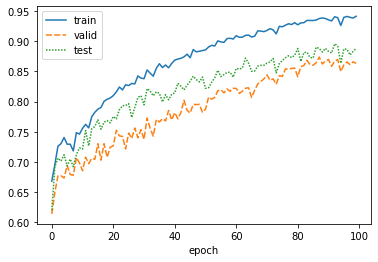

In [57]:
sns.lineplot(data=df_curves)